## Experimental ground: random collection of approaches and testing of different functions

In [6]:
# libraries 
import numpy as np
import time
import h5py
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
import sys
import math
sys.path.insert(0, '../../src')

# from Network.PatchHandler3D import PatchHandler3D
# functions
from testing.test_iterator import check_compatibility, load_indexes
from Network.PatchHandler3D_temporal import PatchHandler4D
import prepare_data.fft_downsampling as fft_fcts
# from utils.evaluate_utils import *
from prepare_data.h5functions import save_to_h5
from utils.evaluate_utils import *
plt.rcParams['figure.figsize'] = [5, 5]
from utils.colors import *
import prepare_data.cfl as cfl

In [7]:
def adjust_image_size_centered(image, new_shape):
    """
    Adjust the size of the image to the new shape, assumes 4D image
    """
    old_shape = image.shape
    
    padding = []

    # pad the image
    for i in range(len(new_shape)):
        # diff positive for padding and negative for cropping
        diff = new_shape[i] - old_shape[i]
        
        if diff > 0:
            # pad the image
            pad_before = diff // 2
            pad_after = diff - pad_before
            padding.append((pad_before, pad_after))
        else:
            # no adjustment needed
            padding.append((0, 0))

        # cropping
        if diff < 0:
            t_mid = int(old_shape[i] // 2)
            cropr = int(np.floor(abs(new_shape[i]) / 2))
            cropl = int(np.ceil(abs(new_shape[i]) / 2))
            if i == 0:
                image = image[t_mid - cropl:t_mid + cropr, :, :, :]
            elif i == 1:
                image = image[:, t_mid - cropl:t_mid + cropr, :, :]
            elif i == 2:
                image = image[:, :, t_mid - cropl:t_mid + cropr, :]
            elif i == 3:
                image = image[:, :, :, t_mid - cropl:t_mid + cropr]

    # pad the image
    new_image = np.pad(image, padding, mode='constant', constant_values=0)

    print(f"Adjusted image size from {old_shape} to {new_image.shape}")
    return new_image


In [70]:
import os
from PIL import Image
# create gifs

def create_gif(directory_path, gif_path, includes = ''):
    # Get all image files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]
    # only include those conatin 'inclusion' word
    image_files = [f for f in image_files if includes in f]

    # Sort the image files by name
    image_files.sort()

    # Create a list to store the image frames
    frames = []

    # Load each image and append it to the frames list
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        frames.append(image)

    # Save the frames as a GIF
    frames[0].save(gif_path, format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)

# Example usage

directory_path = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/results/data/insilico/Model_6'
# create_gif(directory_path, f'{directory_path}/magn.gif', includes='magn')
# create_gif(directory_path, f'{directory_path}/vectorfield.gif', includes='vectorfield')


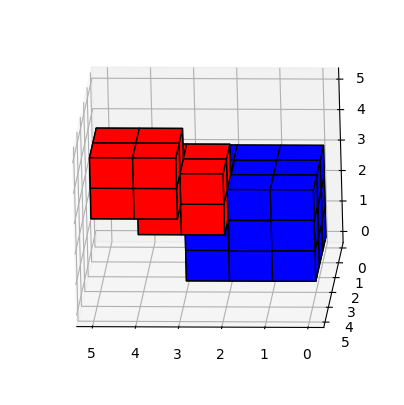

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# prepare some coordinates
x, y, z = np.indices((5, 5, 5))

# draw cuboids in the top left and bottom right corners, and a link between
# them
cube1 = (x < 3) & (y < 3) & (z < 3)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxelarray = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxelarray.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'

# and plot everything
ax = plt.figure().add_subplot(projection='3d', proj_type = 'ortho')
ax.voxels(voxelarray, facecolors=colors, edgecolor='k', shade=False)

# ax.view_init(elev=17, azim=-80, roll = 2.1)
# ax.view_init(elev=20, azim=-80, )
ax.view_init(elev=20, azim=95, roll = 1.5)
plt.show()

# ax.view_init(elev=10, azim=-80, roll = 1)
# plt.show()

(72, 70, 76, 3)
157551 30800


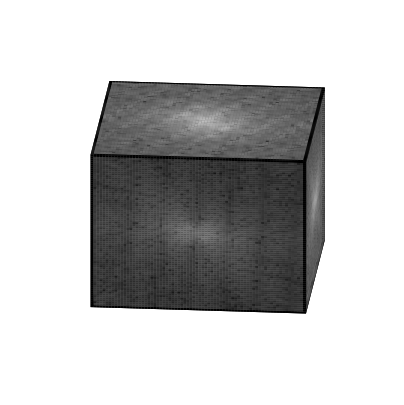

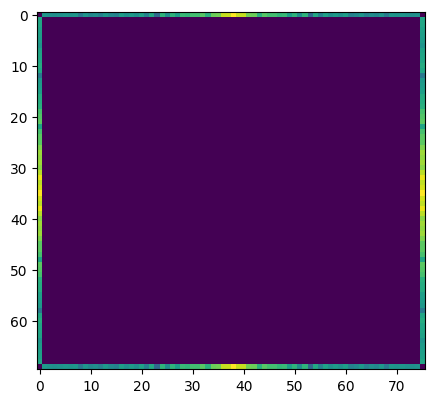

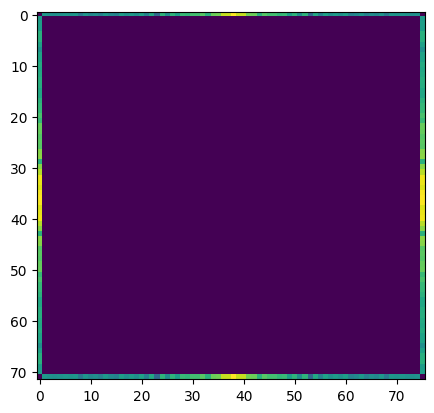

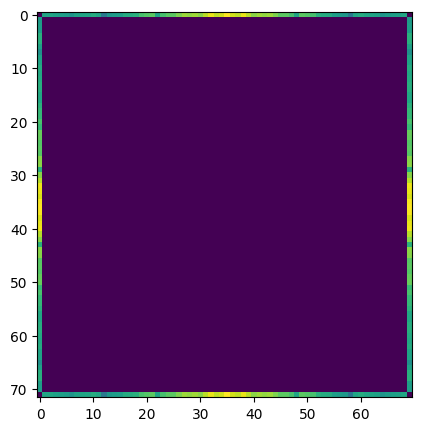

In [3]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


path_model = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'

with h5py.File(path_model, 'r') as hf:
    u = np.array(hf['u'])[0]
    mask = np.array(hf['mask'])[0]


venc = np.max(u)
cmp_img = np.multiply(mask, (1j*(u/venc*np.pi)))
ksp_full = np.abs(fft_fcts.complex_image_to_centered_kspace(cmp_img))

#normalisera
ksp_full = np.log(ksp_full)
# normalize between 0 and 1
ksp_full = (ksp_full - np.min(ksp_full)) / (np.max(ksp_full) - np.min(ksp_full))

x, y, z = ksp_full.shape

# Create axis
axes = [x, y, z]

mid_x = ksp_full[x//2, :, :]
mid_y = ksp_full[:, y//2, :]
mid_z = ksp_full[:, :, z//2]

ksp_full[0, :, :] = mid_x
ksp_full[-1, :, : ] = mid_x
ksp_full[:, 0, :] = mid_y
ksp_full[:, -1, :] = mid_y
ksp_full[:, :, 0] = mid_z
ksp_full[:, :, -1] = mid_z

# set inner part to zero
ksp_full[1:-1, 1:-1, 1:-1] = 0

# Create Data
data = np.zeros(axes)
data[np.where(ksp_full != 0)] = 1
data.astype(bool)

# ksp_full[-1, -1, :] = 0 
# ksp_full[-1,  0, :] = 0
# ksp_full[0,  -1, :] = 0 
# ksp_full[0,   0, :] = 0

# ksp_full[0,  :, -1] = 0 
# ksp_full[0,   :, 0] = 0 
# ksp_full[-1, :, -1] = 0 
# ksp_full[-1,  :, 0] = 0 

# ksp_full[:, -1, -1] = 0 
# ksp_full[:, -1,  0] = 0
# ksp_full[:, 0,  -1] = 0 
# ksp_full[:, 0,   0] = 0

# Control colour
colors = np.empty(axes + [3], dtype=np.float32)

print(colors.shape)
b_x, b_y, b_z = np.where(ksp_full !=0)

colors[b_x, b_y,b_z , 0] = ksp_full[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 1] = ksp_full[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 2] = ksp_full[b_x, b_y,b_z]


print(np.count_nonzero(colors), np.count_nonzero(data))

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
ax.voxels(data, facecolors=colors, shade=False)
plt.grid(b=None) # Hide grid lines
plt.axis('off') # Hide axes ticks
ax.view_init(elev=20, azim=95, ) # Set the view angle
# ax.view_init(elev=17, azim=-80, roll = 2.1)

plt.show()

Adjusted image size from (1, 72, 126, 104) to (1, 72, 70, 76)
min/max 0.0 24004.21
min/max 0.0 10.086026
min/max 0.0 1.0
(72, 70, 76, 3)
682861 30800 9216
647848 30800 9216


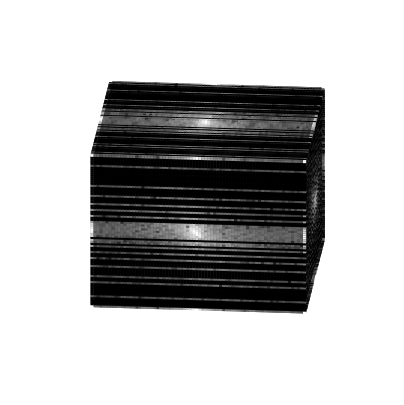

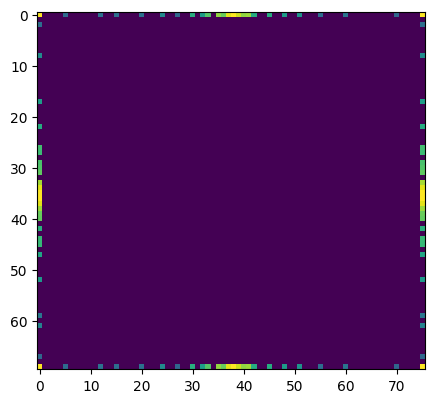

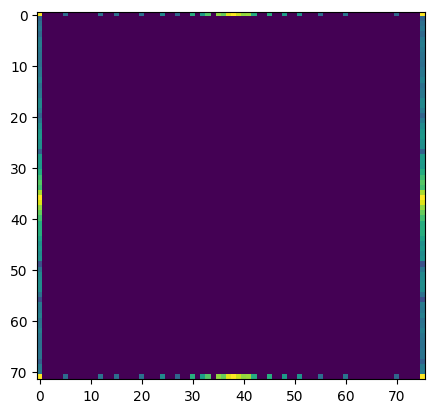

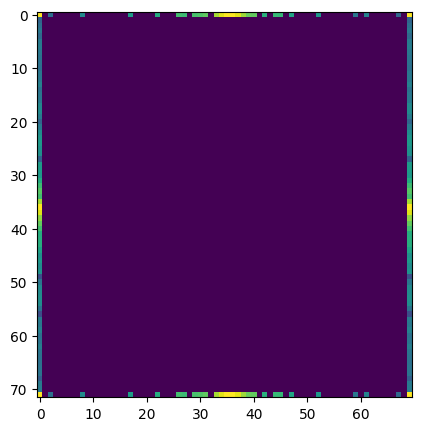

In [ ]:
path_ksp = f'../../results/kspacesampling/final/ksp/u_kspace_M1_hr'

ksp_sparse = np.abs(cfl.readcfl(path_ksp).squeeze()[:, :, :, 0,  0])
ksp_sparse = adjust_image_size_centered(ksp_sparse[np.newaxis, ... ], (1, *ksp_full.shape)).squeeze()

print('min/max', np.min(ksp_sparse), np.max(ksp_sparse))
ksp_sparse +=1
#normalisera
ksp_sparse = np.log(ksp_sparse)
print('min/max', np.min(ksp_sparse), np.max(ksp_sparse))
# normalize between 0 and 1
ksp_sparse = (ksp_sparse - np.min(ksp_sparse)) / (np.max(ksp_sparse) - np.min(ksp_sparse))
print('min/max', np.min(ksp_sparse), np.max(ksp_sparse))

x, y, z = ksp_sparse.shape

# Create axis
axes = [x, y, z]

mid_x = ksp_sparse[x//2, :, :]
mid_y = ksp_sparse[:, y//2, :]
mid_z = ksp_sparse[:, :, z//2]

ksp_sparse[0, :,  :] = mid_x
ksp_sparse[-1, :, :] = mid_x
ksp_sparse[:, 0,  :] = mid_y
ksp_sparse[:, -1, :] = mid_y
ksp_sparse[:, :,  0] = mid_z
ksp_sparse[:, :, -1] = mid_z

# set inner part of cube to zero
ksp_sparse[1:-1, 1:-1, 1:-1] = 0

# Create Data
data = np.zeros(ksp_sparse.shape)
data[0, :,  :] = 1
data[-1, :, :] = 1
data[:, 0,  :] = 1
data[:, -1, :] = 1
data[:, :,  0] = 1
data[:, :, -1] = 1

# ksp_sparse[-1, -1, :] = 0 
# ksp_sparse[-1,  0, :] = 0
# ksp_sparse[0,  -1, :] = 0 
# ksp_sparse[0,   0, :] = 0

# ksp_sparse[0,  :, -1] = 0 
# ksp_sparse[0,   :, 0] = 0 
# ksp_sparse[-1, :, -1] = 0 
# ksp_sparse[-1,  :, 0] = 0 

# ksp_sparse[:, -1, -1] = 0 
# ksp_sparse[:, -1,  0] = 0
# ksp_sparse[:, 0,  -1] = 0 
# ksp_sparse[:, 0,   0] = 0

# Control colour
colors = np.empty(axes + [3], dtype=np.float32)

print(colors.shape)
b_x, b_y, b_z = np.where(data == 1)
data.astype(bool)

print(np.count_nonzero(colors), np.count_nonzero(data), np.count_nonzero(ksp_sparse))

colors[b_x, b_y, b_z, 0] = ksp_sparse[b_x, b_y, b_z]
colors[b_x, b_y, b_z, 1] = ksp_sparse[b_x, b_y, b_z]
colors[b_x, b_y, b_z, 2] = ksp_sparse[b_x, b_y, b_z]

print(np.count_nonzero(colors), np.count_nonzero(data), np.count_nonzero(ksp_sparse))

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
ax.voxels(data, facecolors=colors, shade=False)
plt.grid(b=None) # Hide grid lines
plt.axis('off')  # Hide axes ticks
ax.view_init(elev=20, azim=5, roll=1.3) # Set the view angle
# ax.view_init(elev=17, azim=-80, roll = 2.1)

plt.show()

plt.imshow(mid_x)
plt.show()

plt.imshow(mid_y)
plt.show()

plt.imshow(mid_z)
plt.show()

Adjusted image size from (72, 126, 104, 1) to (72, 70, 76, 1)
(72, 70, 76, 3)
1058064 30800
Plot figure ..


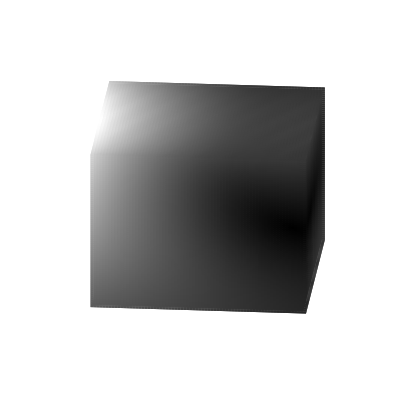

In [11]:
# Import libraries
from mpl_toolkits.mplot3d import Axes3D

path_csm = f'../../results/kspacesampling/csm/csm_64_126_resized'
csm = cfl.readcfl(path_csm)

csm_1 = np.abs(csm[..., 2])
csm_1 = adjust_image_size_centered(np.expand_dims(csm_1, -1), (*ksp_full.shape, 1)).squeeze()

# set middle to zero
csm_1[1:-1, 1:-1, 1:-1] = 0

# normalisera
csm_1 /= np.max(csm_1)

x, y, z = csm_1.shape

# Create axis
axes = [x, y, z]

# Control colour
colors = np.empty(axes + [3], dtype=np.float32)

b_x, b_y, b_z = np.where(csm_1 !=0)

colors[b_x, b_y,b_z , 0] = csm_1[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 1] = csm_1[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 2] = csm_1[b_x, b_y,b_z]

data = np.zeros(axes)
data[np.where(csm_1 != 0 )] = 1
data.astype(bool)

print(colors.shape)

print(np.count_nonzero(colors), np.count_nonzero(data))

print('Plot figure ..')
# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')
ax.voxels(data, facecolors=colors, shade=False)
plt.grid(b=None) # Hide grid lines
plt.axis('off') # Hide axes ticks
ax.view_init(elev=20, azim=95, roll=1.3) # Set the view angle
# Set the view angle
# ax.view_init(elev=17, azim=-80, roll = 2.1)

plt.show()

(72, 70, 76, 3)


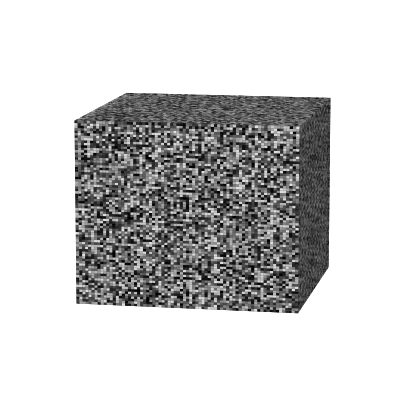

In [23]:
noise_data = np.random.rand(*csm_1.shape)

# Control colour
colors = np.empty(axes + [3], dtype=np.float32)

print(colors.shape)

b_x, b_y, b_z = np.where(csm_1 !=0)

colors[b_x, b_y,b_z , 0] = noise_data[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 1] = noise_data[b_x, b_y,b_z]
colors[b_x, b_y,b_z , 2] = noise_data[b_x, b_y,b_z]

data = np.zeros(axes)
data[np.where(csm_1 != 0 )] = 1
data.astype(bool)

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Voxels is used to customizations of the
# sizes, positions and colors.
ax.voxels(data, facecolors=colors)

# Hide grid lines
plt.grid(b=None)

# Hide axes ticks
plt.axis('off')
# Set the view angle
ax.view_init(elev=17, azim=-80, roll = 2.1)

../../results/kspacesampling/final/output_M1_hr_u_l2_i10 nframes: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


../../results/kspacesampling/final/output_M1_hr_u_i10 nframes: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


../../results/kspacesampling/final/output_M1_hr_u_L2 nframes: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


../../results/kspacesampling/final/output_M1_hr_u_orig nframes: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


../../results/kspacesampling/final/output_M1_hr_u_fpqr nframes: 50


MovieWriter ffmpeg unavailable; using Pillow instead.


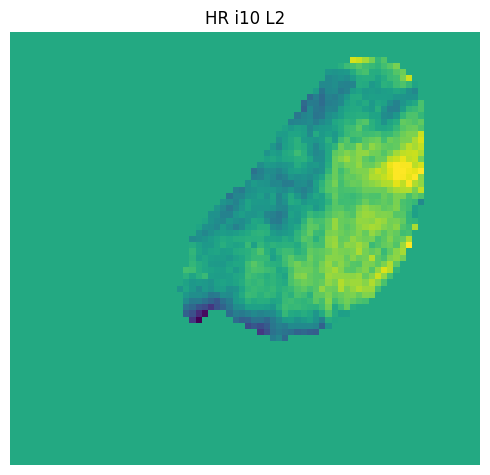

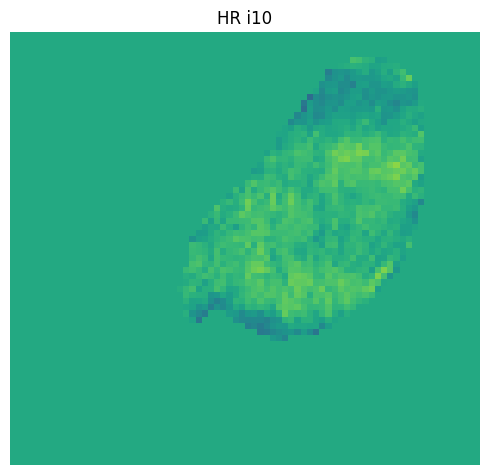

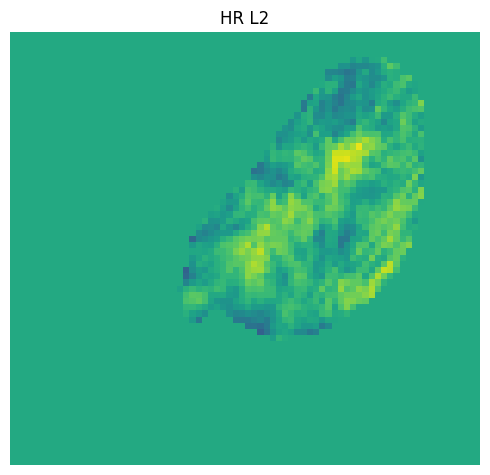

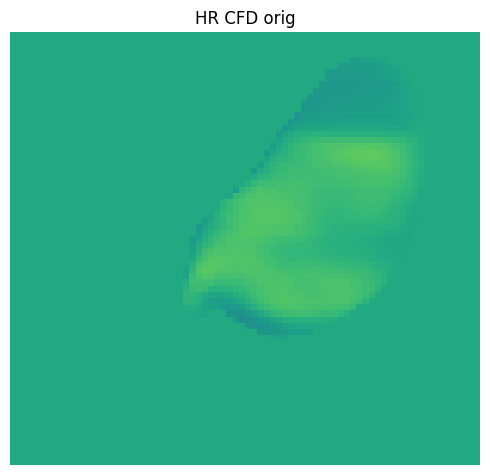

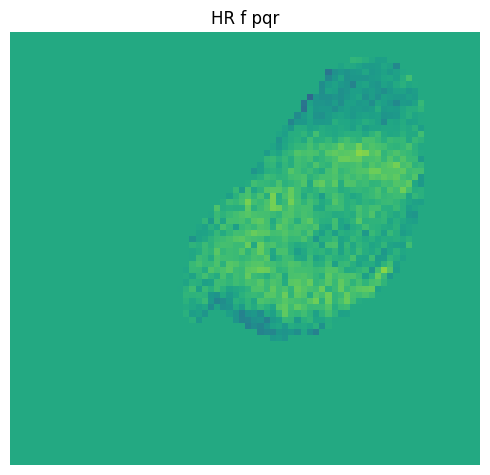

In [2]:

orig_data = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'
path_lr = "../../results/kspacesampling/final/output_M1_lr.h5"
path_hr_i10 = "../../results/kspacesampling/final/output_M1_hr_i10.h5"
path_hr_l2 = "../../results/kspacesampling/final/output_M1_hr_l2.h5"
path_hr_i10_l2 = "../../results/kspacesampling/final/output_M1_hr_l2_i10.h5"
path_hr_fpqr = "../../results/kspacesampling/final/output_M1_hr_fpqr.h5"
path_ksp = f'../../results/kspacesampling/final/ksp/u_kspace_M1_hr'



with h5py.File(orig_data, 'r') as hf:
    mask = np.array(hf['mask'])
    u_orig  = np.array(hf['u'])

with h5py.File(path_hr_fpqr, 'r') as hf:
    u_hr_fpqr = np.array(hf['u'])

with h5py.File(path_hr_i10, 'r') as hf:
    u_hr_i10 = np.array(hf['u'])

with h5py.File(path_hr_l2, 'r') as hf:
    u_hr_l2 = np.array(hf['u'])

with h5py.File(path_hr_i10_l2, 'r') as hf:
    u_hr_l2_i10 = np.array(hf['u'])

with h5py.File(path_lr, 'r') as hf:
    u_lr = np.array(hf['u'])

# u_ksp_sampled = cfl.readcfl(path_ksp).squeeze().transpose(4, 0, 1, 2, 3 )
# u_ksp_sampled = u_ksp_sampled[:, :, :, :, 0]
# u_recon = np.angle(fft_fcts.centered_kspace_to_complex_img(u_ksp_sampled))/np.pi * (np.max(u_orig))

# print(np.max(u_recon), np.min(u_recon))
# plt.imshow(u_recon[20, :, :])
# plt.show()


def create_temporal_comparison_gif_single(idx, data,  path,title= '',  fps = 10):

    min_v = np.min(u_orig[:, idx, :, :])
    max_v = np.max(u_orig[:, idx, :, :])

    N_frames = data.shape[0]
    print(path, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, idx, :, :],interpolation='none' , vmin=min_v, vmax=max_v)
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init, frames = N_frames, interval = 100) # in ms)
    anim.save(f'{path}.gif', fps=fps)


create_temporal_comparison_gif_single(20, u_hr_l2_i10,'../../results/kspacesampling/final/output_M1_hr_u_l2_i10' ,title=  'HR i10 L2', fps =20 )
create_temporal_comparison_gif_single(20, u_hr_i10,'../../results/kspacesampling/final/output_M1_hr_u_i10' , title='HR i10',  fps =20 )
create_temporal_comparison_gif_single(20, u_hr_l2,'../../results/kspacesampling/final/output_M1_hr_u_L2' , title='HR L2',  fps =20 )
create_temporal_comparison_gif_single(20, u_orig,'../../results/kspacesampling/final/output_M1_hr_u_orig' , title='HR CFD orig',  fps =20 )
create_temporal_comparison_gif_single(20, u_hr_fpqr,'../../results/kspacesampling/final/output_M1_hr_u_fpqr' , title='HR f pqr',  fps =20 )
# create_temporal_comparison_gif_single(20, u_lr,'../../results/kspacesampling/final/output_M1_lr_u' , fps =10 )
# create_temporal_comparison_gif_single(20, u_recon,'../../results/kspacesampling/final/output_M1_reconstr_u_hr' , fps =10 )
# create_temporal_comparison_gif_single(20, u_recon*adjust_image_size(mask, u_recon.shape),'../../results/kspacesampling/final/output_M1_reconstr_u_hr_masked' , fps =10 )

### Check on compressed sensing results

In [3]:
def adjust_image_size(image, new_shape):
    """
    Adjust the size of the image to the new shape, assumes 4D image
    """
    old_shape = image.shape
    
    padding = []

    # pad the image
    for i in range(len(new_shape)):
        # diff positive for padding and negative for cropping
        diff = new_shape[i] - old_shape[i]
        
        if diff > 0:
            # pad the image
            pad_before = diff // 2
            pad_after = diff - pad_before
            padding.append((pad_before, pad_after))
        else:
            # no adjustment needed
            padding.append((0, 0))

        #cropping
        if diff < 0:
            t_mid = int(old_shape[i] // 2)
            cropr = int(np.floor(abs(new_shape[i]) / 2))
            cropl = int(np.ceil(abs(new_shape[i]) / 2))
            if i == 0:
                image = image[t_mid - cropl:t_mid + cropr, :, :, :]
            elif i == 1:
                image = image[:, t_mid - cropl:t_mid + cropr, :, :]
            elif i == 2:
                image = image[:, :, t_mid - cropl:t_mid + cropr, :]
            elif i == 3:
                image = image[:, :, :, t_mid - cropl:t_mid + cropr]

    # pad the image
    new_image = np.pad(image, padding, mode='constant', constant_values=0)

    print(f"Adjusted image size from {old_shape} to {new_image.shape}")
    return new_image

# get phase image
def phase_norm_to_vel(phase, min_vel, max_vel):
    return (phase + np.pi) / np.pi * (max_vel - min_vel) + min_vel


In [3]:
# load data

data_models = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
vel = ['u', 'v', 'w']

idx = np.index_exp[0, 20, :, :]

#output_{vel}_{model_name}_{res}
# load data
for m in data_models:
    orig_model = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic.h5'
    orig_lr =  f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic_noise.h5'

    for v in vel:
        with h5py.File(orig_model, 'r') as hf:
            vel_orig = np.array(hf[v])
            mask = np.array(hf['mask'])
            t, x, y, z = vel_orig.shape 
        
        with h5py.File(orig_lr, 'r') as hf:
            lr_orig = np.array(hf[v])

        path = f'../../results/kspacesampling/output_{v}_{m}'
        lr = cfl.readcfl(f'{path}_lr').squeeze().transpose(3, 0, 1,2)
        hr = np.ones_like(vel_orig)#cfl.readcfl(f'{path}_hr').squeeze().transpose(3, 0, 1,2)

        lr = adjust_image_size(lr, (lr.shape[0], x, y, z))
        hr = adjust_image_size(hr, (hr.shape[0], x, y, z))

        lr = phase_norm_to_vel(np.angle(lr) - np.pi, vel_orig.min(), vel_orig.max())
        hr = phase_norm_to_vel(np.angle(hr), vel_orig.min(), vel_orig.max())
        print(np.sum(np.abs(hr)))
        
        plt.figure(figsize = (10, 10))
        plt.subplot(1, 5, 1)
        plt.imshow(lr[idx])
        plt.title(f'{m}_{v} - lr')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(lr[idx]*mask[idx])
        plt.title(f'{m}_{v} - lr fluid ')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(lr_orig[idx]*mask[idx])
        plt.title(f'{m}_{v} - lr fluid orig.')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(hr[idx])
        plt.title(f'{m}_{v} - hr')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(vel_orig[idx])
        plt.title(f'{m}_{v} - orig')
        plt.axis('off')

        plt.show()


        print(f'{m}_{v} - lr: {lr.shape} - hr: {hr.shape}')
        psnr_u = peak_signal_to_noise_ratio(vel_orig[::2], lr)
        psnr_u_fluid = peak_signal_to_noise_ratio(vel_orig[::2], lr*mask[::2])
        print('peak snr', psnr_u.round(3), 'psnr (fluid region)',  psnr_u_fluid.round(3))
        psnr_u_orig = peak_signal_to_noise_ratio(vel_orig, lr_orig)
        psnr_u_fluid_orig = peak_signal_to_noise_ratio(vel_orig, lr_orig*mask)
        print('peak snr orig', psnr_u_orig.round(3), 'psnr (fluid region) orig',  psnr_u_fluid_orig.round(3))



KeyboardInterrupt: 

In [20]:
csm_path = "results/kspacesampling/csm_64_126_resized"
csm = cfl.readcfl(csm_path)

AttributeError: module 'prepare_data.cfl' has no attribute 'loadcfl'

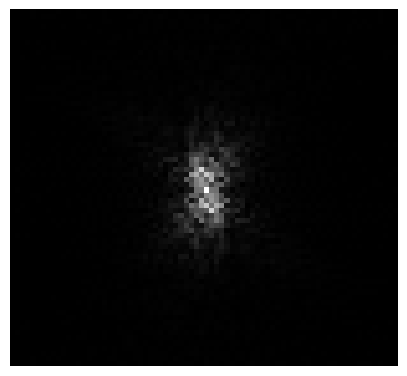

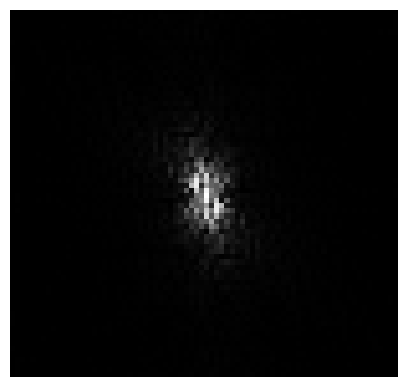

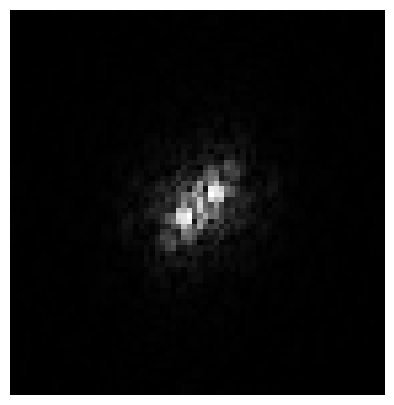

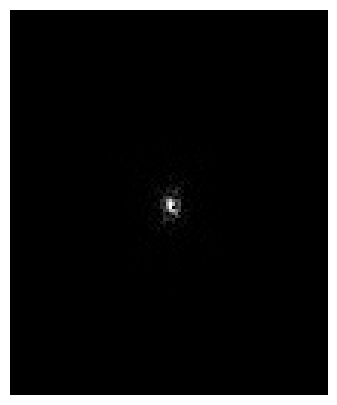

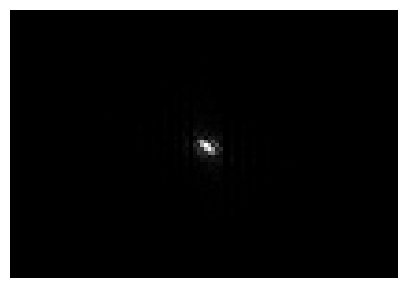

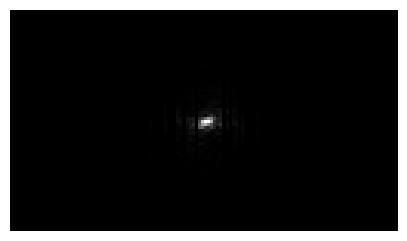

In [69]:
from mpl_toolkits.mplot3d import Axes3D
path_model = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'
path_ksp = f'../../results/kspacesampling/final/ksp/u_kspace_M1_hr'


with h5py.File(orig_model, 'r') as hf:
    u = np.array(hf['u'])
    mask = np.array(hf['mask'])


venc = np.max(u)
cmp_img = np.multiply(mask, (1j*(u/venc*np.pi)))
ksp_full = fft_fcts.complex_image_to_centered_kspace(cmp_img)

t, x, y, z = ksp_full.shape

plt.imshow(np.abs(ksp_full[0, x//2, :, :]), cmap = 'Greys_r')
plt.axis('off')
plt.show()

plt.imshow(np.abs(ksp_full[0, :, y//2, :]), cmap = 'Greys_r')
plt.axis('off')
plt.show()

plt.imshow(np.abs(ksp_full[0, :, :, z//2]), cmap = 'Greys_r')
plt.axis('off')
plt.show()

u_ksp_sampled = cfl.readcfl(path_ksp).squeeze().transpose(4, 0, 1, 2, 3 )
u_ksp_sampled = np.abs(u_ksp_sampled[0, :, :, :, 0])
# print(u.shape, u_ksp_sampled.shape)
x_k, y_k, z_k = u_ksp_sampled.shape

plt.imshow(u_ksp_sampled[x_k//2, :, :], cmap = 'Greys_r')
plt.axis('off')
plt.show()

plt.imshow(u_ksp_sampled[:, y_k//2, :], cmap = 'Greys_r')
plt.axis('off')
plt.show()

plt.imshow(u_ksp_sampled[:, :, z_k//2], cmap = 'Greys_r')
plt.axis('off')
plt.show()

In [ ]:
# 3D 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate coordinates for the k-space matrix
x, y, z = np.indices(u_ksp_sampled.shape)
norm = plt.Normalize(vmin=np.min(np.abs(u_ksp_sampled)), vmax=np.max(np.abs(u_ksp_sampled)))
# Create the figure and the 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Flatten the arrays for easier plotting
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = np.abs(u_ksp_sampled).flatten()

# Plot each point in the k-space
sc = ax.scatter(x, y, z, c=values, cmap='Greys_r', alpha=norm(values))

# Add color bar for reference
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Intensity')

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('kz')


In [ ]:
# test norm 0 and 2 pi
orig_model = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic.h5'


In [6]:
def vel_to_phase(vel, venc):
    return (vel/venc)*np.pi + np.pi

def phase_to_vel(phase, venc):
    return ((phase- np.pi)/np.pi)*venc


min/max vel 0.0 3.7876067
min/max compl img -3.1415925 3.1415925
min/max compl rev -3.1415925796243167 3.1415925105984845
True


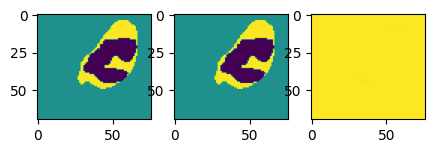

In [41]:
m = 'M1'
orig_model  =  f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic.h5'

v = 'u'
with h5py.File(orig_model, 'r') as hf:
    vel = np.array(hf[v])
    magn = np.array(hf['mask'])

venc = np.max(np.abs(vel))
vel = vel/venc * np.pi + np.pi

complex_img =  np.multiply(magn, np.exp(1j * vel) )
kspace = fft_fcts.complex_image_to_centered_kspace(complex_img)
rev_c = fft_fcts.centered_kspace_to_complex_img(kspace)

idxs = np.index_exp[0, 20, :, :]
min_v = -np.pi
max_v = np.pi

print('min/max vel', np.min(vel), np.max(vel))
print('min/max compl img', np.min(np.angle(complex_img)), np.max(np.angle(complex_img)))
print('min/max compl rev', np.min(np.angle(rev_c)), np.max(np.angle(rev_c)))
plt.subplot(1, 3, 1)
plt.imshow(magn[idxs]*np.angle(complex_img[idxs]), vmin= min_v, vmax=max_v)
plt.subplot(1, 3, 2)
plt.imshow(magn[idxs]*np.angle(rev_c[idxs]), vmin=min_v, vmax=max_v)

plt.subplot(1, 3, 3)
plt.imshow(vel[idxs], vmin=min_v, vmax=max_v)

print(np.allclose(complex_img*magn, rev_c*magn, atol=1e-10), )

In [35]:
m = 'M1'
orig_model  =  f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic.h5'
orig_lr     =  f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic_noise.h5'

v = 'u'
with h5py.File(orig_model, 'r') as hf:
    vel_orig = np.array(hf[v])
    venc = np.max(np.asarray(hf[f'{v}_max']))
    venc = 3.037533
    print('venc', venc) # 3.037533
    mask = np.array(hf['mask'])
    t, x, y, z = vel_orig.shape 

with h5py.File(orig_lr, 'r') as hf:
    lr_orig = np.array(hf[v])

path_hr = f'../../results/kspacesampling/oldresults/output_M1_hr/output_{v}_{m}'
path_lr = f'../../results/kspacesampling/final/output_{v}_{m}'

lr = cfl.readcfl(f'{path_lr}_lr').squeeze().transpose(3, 0, 1,2)
hr = cfl.readcfl(f'{path_hr}_hr').squeeze().transpose(3, 0, 1,2)

lr = adjust_image_size(lr, (lr.shape[0], x, y, z))
hr = adjust_image_size(hr, (hr.shape[0], x, y, z))

lr = np.angle(lr)
hr = np.angle(hr)

venc 3.037533
Adjusted image size from (25, 72, 126, 104) to (25, 72, 70, 76)
Adjusted image size from (50, 192, 126, 104) to (50, 72, 70, 76)


In [36]:
# denormalize -> phase to vel

print('min and max of lr ', lr.min(), lr.max())
lr_norm1 = (lr)/np.pi*venc#phase_to_vel(np.angle(lr), venc)#phase_norm_to_vel(np.angle(lr), vel_orig.min(), vel_orig.max())
hr_norm1 = phase_norm_to_vel(hr - np.pi, vel_orig.min(), vel_orig.max())

lr_norm2 = ((lr- np.pi)/np.pi)*venc
lr_norm3 = phase_norm_to_vel(lr, vel_orig.min(), vel_orig.max())


min and max of lr  -3.1415925 3.1415927


diff [-2.10198648e-02 -1.58789456e-02 -5.80424815e-03  3.43811512e-03
  1.49916075e-02  6.82711974e-03  1.05442107e-03  2.48765596e-03
  3.24698188e-03  1.74695253e-03  8.54598358e-04  2.14592274e-03
  2.05859542e-03  2.17757002e-03  1.40244700e-03  2.56875530e-04
  2.10292637e-06 -1.10442564e-03 -1.81092415e-03 -5.00500202e-04
  1.40879303e-04  1.64117711e-03  6.99352194e-03 -1.04137510e-03
 -9.57369059e-03]


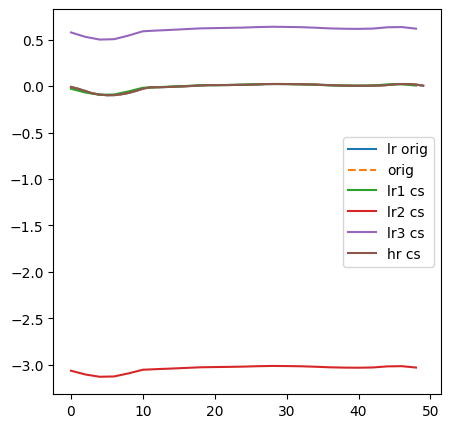

In [37]:
t_range_lr = np.arange(0, t, 2)
plt.plot(np.mean(lr_orig, axis=(1, 2, 3), where=mask.astype(bool)), label='lr orig')
plt.plot(np.mean(vel_orig, axis=(1, 2, 3), where=mask.astype(bool)),'--',  label='orig')
plt.plot(t_range_lr, np.mean(lr_norm1, axis=(1, 2, 3), where=mask.astype(bool)[::2]), label='lr1 cs')
plt.plot(t_range_lr, np.mean(lr_norm2, axis=(1, 2, 3), where=mask.astype(bool)[::2]), label='lr2 cs')
plt.plot(t_range_lr, np.mean(lr_norm3, axis=(1, 2, 3), where=mask.astype(bool)[::2]), label='lr3 cs')
plt.plot(np.mean(hr_norm1, axis=(1, 2, 3), where=mask.astype(bool)), label='hr cs')  
plt.legend()
print('diff', np.mean(lr, axis=(1, 2, 3), where=mask.astype(bool)[::2]) -  np.mean(vel_orig[::2], axis=(1, 2, 3), where=mask.astype(bool)[::2]))

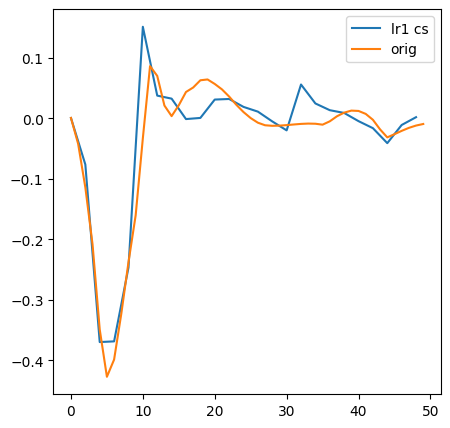

In [38]:
idx = np.index_exp[:, 40, 25, 30]
t_range_lr = np.arange(0, vel_orig.shape[0], 2)
plt.plot(t_range_lr, lr_norm1[idx], label = 'lr1 cs')
# plt.plot(t_range_lr, lr_norm2[idx], label = 'lr2 cs')
# plt.plot(t_range_lr, lr_norm3[idx], label = 'lr3 cs')
# plt.plot(hr[idx], label = 'hr cs')
plt.plot(vel_orig[idx], label = 'orig')
plt.legend()

(-0.5, 75.5, 69.5, -0.5)

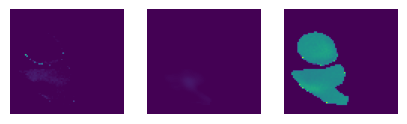

In [39]:
max_vel = np.max(hr*mask)
min_vel = np.min(hr*mask)
idx_show = np.index_exp[2, 40, :, :]
plt.subplot(1, 3, 1)
plt.imshow(lr_norm1[idx_show]*mask[idx_show], vmin=min_vel, vmax = max_vel)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(vel_orig[idx_show]*mask[idx_show], vmin=min_vel, vmax = max_vel)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow((hr[idx_show] - lr_norm1[idx_show])*mask[idx_show])
plt.axis('off')


In [40]:
max_vel = np.max(vel_orig*mask)-0.1
min_vel = np.min(vel_orig*mask)+0.1

@widgets.interact(frame=(0, hr.shape[0]-1), x = (0, hr.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(7,7))
    N = 3
    idxs = get_indices(frame,axis, x)
    idx_lr = get_indices(frame//2,axis, x)


    plt.subplot(1, N, 1)
    plt.imshow(lr_norm1[idx_lr]*mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis') #vmin = min_vel, vmax = max_vel,
    plt.title('lr cs')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(vel_orig[idxs]*mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis')
    plt.title('orig cs')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow((hr[idxs]-lr_norm1[idx_lr]) *mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis')
    diff_max = np.max(np.abs((hr[idxs]-lr_norm1[idx_lr]) *mask[idxs]))
    plt.title(f'diff max {diff_max:.4f} m/s')
    plt.axis('off')

interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=10, description='x', ma…

In [ ]:
# delete this later
m = 'M1'
orig_model = f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic.h5'
orig_lr =  f'/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/{m}_2mm_step2_static_dynamic_noise.h5'

v = 'u'
with h5py.File(orig_model, 'r') as hf:
    vel_orig = np.array(hf[v])
    mask = np.array(hf['mask'])
    t, x, y, z = vel_orig.shape 

with h5py.File(orig_lr, 'r') as hf:
    lr_orig = np.array(hf[v])

path_hr = f'../../results/kspacesampling/output_M1_hr/output_{v}_{m}'
path_lr = f'../../results/kspacesampling/output_{v}_{m}'
lr = cfl.readcfl(f'{path_lr}_lr').squeeze().transpose(3, 0, 1,2)
hr = cfl.readcfl(f'{path_hr}_hr').squeeze().transpose(3, 0, 1,2)#np.ones_like(vel_orig)#cfl.readcfl(f'{path}_hr').squeeze().transpose(3, 0, 1,2)
hr2 =  cfl.readcfl(f'../../results/kspacesampling/output_M1_hr_nocoilsens').squeeze().transpose(3, 0, 1,2)

lr = adjust_image_size(lr, (lr.shape[0], x, y, z))
hr = adjust_image_size(hr, (hr.shape[0], x, y, z))
hr2 = adjust_image_size(hr2, (hr2.shape[0], x, y, z))

lr = phase_norm_to_vel(np.angle(lr) - np.pi, vel_orig.min(), vel_orig.max())
hr = phase_norm_to_vel(np.angle(hr) - np.pi, vel_orig.min(), vel_orig.max())
hr2 = phase_norm_to_vel(np.angle(hr2) - np.pi, vel_orig.min(), vel_orig.max())
print(np.sum(np.abs(hr)))

t_range_lr = np.arange(0, t, 2)
plt.plot(np.mean(lr_orig, axis=(1, 2, 3), where=mask.astype(bool)), label='lr orig')
plt.plot(np.mean(vel_orig, axis=(1, 2, 3), where=mask.astype(bool)),'--',  label='orig')
plt.plot(t_range_lr, np.mean(lr, axis=(1, 2, 3), where=mask.astype(bool)[::2]), label='lr cs')
plt.plot(np.mean(hr, axis=(1, 2, 3), where=mask.astype(bool)), label='hr cs')  
plt.plot(np.mean(hr2, axis=(1, 2, 3), where=mask.astype(bool)), label='hr2 cs no coil sensitivity')  
plt.legend()
plt.show()

idx = np.index_exp[:, 35, 25, 30]
t_range_lr = np.arange(0, vel_orig.shape[0], 2)
plt.plot(t_range_lr, lr[idx], label = 'lr cs')
plt.plot(hr[idx], label = 'hr cs')
plt.plot(hr2[idx], label = 'hr cs no coil sensitivity')
plt.plot(vel_orig[idx], label = 'orig')
plt.legend()

In [ ]:
@widgets.interact(frame=(0, hr.shape[0]-1), x = (0, hr.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(7,7))
    N = 4
    idxs = get_indices(frame,axis, x)
    idx_lr = get_indices(frame//2,axis, x)


    plt.subplot(1, N, 1)
    plt.imshow(lr[idx_lr]*mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis')
    plt.title('lr cs')
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(hr[idxs]*mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis')
    plt.title('hr cs')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(hr2[idxs]*mask[idxs],  vmin = min_vel, vmax = max_vel, cmap='viridis')
    # diff_max = np.max(np.abs((hr[idxs]-lr[idx_lr]) *mask[idxs]))
    # plt.title(f'diff max {diff_max:.4f} m/s')
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow((hr2[idxs]-hr[idxs])*mask[idxs],  cmap='viridis')
    diff_max = np.max(np.abs((hr[idxs]-hr2[idxs]) *mask[idxs]))
    plt.title(f'diff max {diff_max:.4f} m/s')
    plt.axis('off')

In [ ]:
def complex_image_to_centered_kspace(complex_img):

    if len(complex_img.shape) == 3:
        axes = (0, 1, 2)
    elif len(complex_img.shape) == 4:
        axes = (1, 2, 3)
    else:
        print("Error: Unsupported number of dimensions, please extend function to ", len(complex_img.shape), " dimensions.")

    # ifftshift
    complex_img = np.fft.ifftshift(complex_img, axes=axes)

    # fft
    imgfft = np.fft.fftn(complex_img, axes = axes)

    # shift img to center
    imgfft = np.fft.fftshift(imgfft, axes=axes)
    return imgfft

def centered_kspace_to_complex_img(imgfft):
    if len(imgfft.shape) == 3:
        axes = (0, 1, 2)
    elif len(imgfft.shape) == 4:
        axes = (1, 2, 3)
    else:
        print("Error: Unsupported number of dimensions, please extend function to ", len(imgfft.shape), " dimensions.")

    # ifftshift
    imgfft = np.fft.ifftshift(imgfft, axes=axes)

    # ifft
    complex_img = np.fft.ifftn(imgfft, axes = axes)

    # shift img to center
    complex_img = np.fft.fftshift(complex_img, axes=axes)
    return complex_img




In [ ]:
kspace = cfl.readcfl(f'../../results/kspacesampling/u_kspaceM1_hr').squeeze().transpose(4, 0, 1, 2, 3)
print('kspace shape:', kspace.shape)
kspace = kspace[:, :, :, :, 0] #only use one sensitivity map

u_recon   = np.angle(centered_kspace_to_complex_img(kspace))

plt.imshow(np.abs(kspace[0, 100, :, :]))

plt.show() 

In [ ]:


@widgets.interact(frame=(0, u_recon.shape[0]-1), x = (0, u_recon.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(3,3))
    N = 2
    idxs = get_indices(frame,axis, x)

    plt.imshow(u_recon[idxs], vmin=0, vmax=np.pi)
    plt.title('M1 phase image')
    plt.axis('off')


## Check on Signal to noise ratio

In [ ]:
# load coil sens file
save_as = '../../results/kspacesampling'
save_coil_sens = f'{save_as}/coil_sensitivity16_sphere'


coil_images = cfl.readcfl(save_coil_sens).squeeze()
if len(coil_images.shape) == 5:
    coil_images = coil_images.transpose(4, 0, 1, 2, 3)
n_coils = coil_images.shape[-1]

print(coil_images.shape)

for c in range(n_coils):
    coil_image = coil_images[:, :, :, c]
    print(coil_image.dtype, coil_image.max(), coil_image.min())
    plt.subplot(1, n_coils, c+1)
    plt.imshow(np.abs(coil_image[100, :, :]))
    plt.axis('off')

In [ ]:
path_datamodel = '/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'

# load data static and take frist frame
with h5py.File(path_datamodel, 'r') as f:
    M1_u = np.array(f['u'])[0]
    M1_v = np.array(f['v'])[0]
    M1_w = np.array(f['w'])[0]
    venc = np.array(f['u_max'])[0]
    mask = np.array(f['mask'])[0]


In [ ]:
# add noise: 
targetSNRdb = 14
M1_u_noise = fft_fcts.noise_and_downsampling(M1_u, mask, venc, targetSNRdb, add_noise=True, spatial_crop_ratio=1.0)

snr_u = signaltonoise_fluid_region(M1_u, mask)
print(snr_u, targetSNRdb)


### Check k space sampling results and cs reconstruction


In [ ]:
# new new new 
cs_result_path = '../../results/kspacesampling/FromAlex/result_cs.h5'
kspace_path =    '../../results/kspacesampling/FromAlex/alex_ksp'
# cs_result_path =  '../../results/kspacesampling/res_cs_9coils.h5'#'../../results/kspacesampling/output_test16'#'../../results/kspacesampling/res_cs16_9coils_large.h5'
# kspace_path =    '../../results/kspacesampling/u_kspace16'
path_datamodel = '/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'

# load the data
with h5py.File(cs_result_path, 'r') as file:
    print(file.keys())
    cs_result = np.array(file['res'])

# cs_result = reshape_from_cfl(cfl.readcfl(cs_result_path).squeeze())

with h5py.File(path_datamodel, 'r') as f:
    M1_u = np.array(f['u'])[::2]
    M1_u_norm = vel_to_phase_norm(M1_u)
    mask = np.array(f['mask'])[::2]

kspace_orig = cfl.readcfl(kspace_path).squeeze().transpose(4, 0, 1, 2, 3)
print(kspace_orig.shape, np.linalg.norm(kspace_orig[:, :, :, :, 0]-kspace_orig[:, :, :, :, 1]))
kspace_orig0 = kspace_orig[:, :, :, :, 0]

mask_large  = adjust_image_size(mask, kspace_orig0.shape)
vel_p_large = adjust_image_size(M1_u_norm, kspace_orig0.shape)
compl_img   = centered_kspace_to_complex_img(kspace_orig0)

phase_cs   = np.angle(cs_result)*mask_large #np.angle(cs_result)*
phase_orig = np.angle(compl_img)*mask_large


vel_p_large =  (vel_p_large + np.pi)*mask_large
phase_orig  =  (phase_orig  + np.pi)*mask_large

In [ ]:
plt.imshow(phase_cs[0, 100, :, :])

In [ ]:
def phase_norm_to_vel(phase, min_vel, max_vel):
    return (phase + np.pi) / np.pi * (max_vel - min_vel) + min_vel

#note copied to kspace sampling
def vel_to_phase_norm(vel):
    return (vel-np.min(vel))/(np.max(vel) - np.min(vel)) * np.pi - np.pi


#phase to velocity
min_vel = M1_u.min()
max_vel = M1_u.max()
print(min_vel, max_vel)

vel_cs = phase_norm_to_vel(phase_cs-np.pi, min_vel, max_vel) 

voxel_idx = np.index_exp[:, 91, 61, 50]
# # voxel_idx = np.index_exp[:, 90, 60, 52]

voxel_cs   = vel_cs[voxel_idx] 
vel_large  = adjust_image_size(M1_u, kspace_orig0.shape)
voxel_vel = vel_large[voxel_idx]
plt.plot(voxel_cs , label='cs')
# plt.plot(voxel_orig , label='orig') #+ np.pi
plt.plot(voxel_vel  , label='M1 vel') #- np.pi
plt.legend()

In [ ]:
voxel_idx = np.index_exp[:, 91, 61, 50]
# voxel_idx = np.index_exp[:, 90, 60, 52]

voxel_cs   = phase_cs[voxel_idx]
voxel_orig = phase_orig[voxel_idx]
voxel_vel = vel_p_large[voxel_idx]
plt.plot(voxel_cs , label='cs')
plt.plot(voxel_orig , label='orig') #+ np.pi
plt.plot(voxel_vel  , label='M1 vel') #- np.pi
plt.legend()

In [ ]:
min_vel = np.min(vel_p_large)
max_vel = np.max(vel_p_large)

print(f"Min vel: {min_vel}, max vel: {max_vel}")
print(f"Min phase cs: {np.min(phase_cs)}, max phase cs: {np.max(phase_cs)}")
print(f"Min phase orig: {np.min(phase_orig)}, max phase orig: {np.max(phase_orig)}")

@widgets.interact(frame=(0, phase_cs.shape[0]-1), x = (0, phase_cs.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(8,8))
    N = 2
    idxs = get_indices(frame,axis, x)

    plt.subplot(1, 4, 1)
    plt.imshow(vel_p_large[idxs], vmin=0, vmax=np.pi)
    plt.title('M1 phase image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(phase_cs[idxs], vmin=0, vmax=np.pi)
    plt.title('CS phase image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(phase_orig[idxs], vmin=0, vmax=np.pi)
    plt.title('Phase image from kspace')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(phase_orig[idxs]-vel_p_large[idxs])
    plt.title('Diff M1 phase and cd phase')
    plt.axis('off')

In [ ]:

h5_files = ['../../results/kspacesampling/FromAlex/result_cs.h5','../../results/kspacesampling/res_cs16_9coils_large.h5', ]
path_datamodel = '/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data/CARDIAC/M1_2mm_step2_static_dynamic.h5'
colnames = ['res_vel']

# load data
with h5py.File(h5_files[0], 'r') as f:
    alex_res = np.array(f['res'])

with h5py.File(h5_files[1], 'r') as f:
    new_res = np.array(f['resxmask'])

with h5py.File(path_datamodel, 'r') as f:
    M1_u = np.array(f['u'])[::2]
    mask = np.array(f['mask'])[::2]


mask_large = adjust_image_size(mask, alex_res.shape)

alex_res_masked = mask_large * np.angle(alex_res)
new_res_masked  = mask_large * np.angle(new_res)

print(np.linalg.norm(alex_res_masked- new_res_masked))

In [ ]:

@widgets.interact(frame=(0, alex_res_masked.shape[0]-1), x = (0, alex_res_masked.shape[1]-1), axis=[0, 1, 2])
def f(frame=5, x = 10,  axis = 0):
    plt.figure(figsize=(7,7))
    N = 2
    idxs = get_indices(frame,axis, x)

    plt.subplot(1, 3, 1)
    plt.imshow(alex_res_masked[idxs])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(new_res_masked[idxs])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(new_res_masked[idxs] -alex_res_masked[idxs])
    plt.axis('off')


In [ ]:
# implementing a fibbonaci sphere where code is inspired from 
 #   tps://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    # d adapted for an arbitrary sphere radius
def fibonacci_sphere(samples=1000, r= 1):

    points = []
    tangent = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = (1 - (i / float(samples - 1)) * 2) # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)*r  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y*r, z))
        tangent.append((-r*np.cos(theta)*np.sin(phi), 0, r*np.cos(theta)*np.cos(phi)))
    
    return points, tangent

n = 20
s_points, _  = fibonacci_sphere(n, 10)
s_points2, _ = fibonacci_sphere(n, 2)
s_points3, _ = fibonacci_sphere(n, 3)
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter([x[0] for x in s_points], [x[1] for x in s_points], [x[2] for x in s_points])
ax.scatter([x[0] for x in s_points2], [x[1] for x in s_points2], [x[2] for x in s_points2])
ax.scatter([x[0] for x in s_points3], [x[1] for x in s_points3], [x[2] for x in s_points3])
plt.show()

In [ ]:
#
#3D points
radius= 2
center = [0, 0, 0]
normal = [1, 0, 1]
area_vec = [-1, 2, -1]
points = []
angles = np.linspace(0, 2*np.pi, 20)

for a in angles:
    points.append((radius*np.cos(a)*area_vec[0]+ radius*np.cos(a)*(np.cross(normal, area_vec)[0]) + center[0], 
                   radius*np.cos(a)*area_vec[1]+ radius*np.sin(a)*(np.cross(normal, area_vec)[1]) + center[1],
                   radius*np.cos(a)*area_vec[2]+ radius*np.sin(a)*(np.cross(normal, area_vec)[2]) + center[2]))
points = np.array(points)
print(points.shape)
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
ax.scatter(center[0], center[1], center[2], color = 'orange')

#normal vector is the difference between center shere point and the center of the circle

In [ ]:
s_points, tangents = fibonacci_sphere(30, 10)

plt.figure()
ax = plt.subplot(111, projection='3d')
for i, point in enumerate(s_points):
    # create circle for every sphere point
    radius = 1
    normal = np.array(point)/np.linalg.norm(np.array(point)) #since sphere is centered around origin

    tangent1 = np.array(tangents[i]) 
    tangent1 /= np.linalg.norm(tangent1)
    tangent2 = np.cross(normal, tangent1)
    tangent2 /= np.linalg.norm(tangent2)
    points_c = []
    for a in angles:
        points_c.append((radius*np.cos(a)*tangent1[0]+ radius*np.sin(a)*(tangent2[0]) + point[0], 
                         radius*np.cos(a)*tangent1[1]+ radius*np.sin(a)*(tangent2[1]) + point[1],
                         radius*np.cos(a)*tangent1[2]+ radius*np.sin(a)*(tangent2[2]) + point[2]))
    points_c = np.array(points_c)
    ax.scatter(points_c[:,0], points_c[:,1], points_c[:,2], color ='blue')
    ax.scatter(point[0], point[1], point[2], color = 'red')
ax.scatter(0, 0, 0, color = 'orange')

In [ ]:
# Assuming coil_images and data are your input arrays
coil_images = np.random.rand(72, 70, 76, 3)
data = np.random.rand(50, 72, 70, 76)

# Reshape coil_images to (72, 70, 76, 1) to match the last dimension of data
coil_images_reshaped = coil_images[np.newaxis, :, :, :, :]
print( coil_images_reshaped.shape, data.shape)
# Multiply coil_images with data
result = coil_images[np.newaxis, :, :, :, :] * data[..., np.newaxis]

print(result.shape)


result2 = np.zeros((50, 72, 70, 76, 3))
for c in range(3):
    temp_res = coil_images[np.newaxis,  :, :, :, c] * data
    temp_res2 = np.multiply(np.repeat(coil_images[np.newaxis,  :, :, :, c], data.shape[0], axis = 0), data)
    print('diff tem res', np.linalg.norm(temp_res - temp_res2))
    result2[:, :, :,: , c] = temp_res

print('diff', np.linalg.norm(result -result2))

In [ ]:
# check on fft and ifft
data_dir = '/mnt/c/Users/piacal/Code/SuperResolution4DFlowMRI/Temporal4DFlowNet/data'
path_datamodel = f'{data_dir}/CARDIAC/M1_2mm_step2_static_dynamic.h5'


# load data
with h5py.File(path_datamodel, mode = 'r') as h5:
    vel_u = np.array(h5['u'])[::2, :, :, :]
    venc_u = np.max(np.array(h5['u_max']))

magn = np.ones_like(vel_u)

# transform to kspace
u_kspace = fft_fcts.velocity_img_to_centered_kspace(vel_u, magn, venc_u)

plt.imshow(np.abs(u_kspace[0, 20, :, :]))


In [ ]:
# load 
file = '../../results/interpolation/M2_2mm_step1_static_kspace_sampled_coilsens2.h5'
with h5py.File(file, 'r') as f:
    u_sensitivities = np.array(f['u_csens'])
    u = np.array(f['u'])
    coil_sens = np.array(f['sum_coil_images'])

diff = u_sensitivities - u
v_max = np.max(u)
v_min = np.min(u)

# plot

@widgets.interact( x = (0, u.shape[1]-1))
def f(x = 0):
    plt.figure(figsize=(10, 10))
    N  =4
    plt.subplot(1, N, 1)
    plt.imshow(u[ x, :, :], vmin=v_min,  vmax = v_max)
    plt.title('u')
    plt.axis('off')


    plt.subplot(1, N, 2)
    plt.imshow(u_sensitivities[x, :, :], vmin=v_min,  vmax = v_max)
    plt.title('sen u')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(diff[ x, :, :])
    plt.title('diff')
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(np.abs(coil_sens[x, :, :]))
    # plt.colorbar()
    plt.title('coil sens')
    plt.axis('off')



In [ ]:
plt.subplot(1, 2, 1)
plt.hist(u[np.where(u!=0)].flatten(), bins=100)
plt.ylim(0, 23000)
plt.xlim(-1, 1)
plt.title('u')
plt.subplot(1, 2, 2)
plt.hist(u_sensitivities[np.where(u!=0)].flatten(), bins=100)
plt.title('u sensitivy filtered')
plt.ylim(0, 23000)
plt.xlim(-1, 1)

## test different box averaging strategies

In [ ]:
from prepare_data.temporal_downsampling import temporal_box_averaging_and_downsampling

data_dir = '../../data/CARDIAC/'
hr_box_path = 'M4_2mm_step2_cloudmagnRot_boxavg_HRfct.h5'
lr_box_path = 'M4_2mm_step2_cloudmagnRot_boxavg_LRfct_noise.h5'
hrhr_box_path = 'M4_2mm_step1_static_dynamic.h5'

lr_data = {}
hr_data = {}
with h5py.File(f'{data_dir}{hr_box_path}', 'r') as f:
    for k in f.keys():
        hr_data[k] = np.array(f[k]).squeeze()
with h5py.File(f'{data_dir}{lr_box_path}', 'r') as f:
    for k in f.keys():
        lr_data[k] = np.array(f[k]).squeeze()


plt.figure(figsize=(15, 5))

vel_colnames = ['u', 'v', 'w']
for i, vel in enumerate(vel_colnames):
    plt.subplot(1, 3, i+1)
    t_range = range(0, hr_data[vel].shape[0])
    plt.plot(t_range, np.average(hr_data[vel], axis=(1, 2, 3),weights = lr_data['mask']), label=f'HR_{vel}', color = 'black')
    plt.plot(t_range[::2], np.average(lr_data[vel][::2], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 1')
    plt.plot(t_range[::2], np.average(lr_data[vel][1::2], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 2')


    plt.legend()

plt.tight_layout()
plt.show()

hrhr_data = {}
# part 2: self sampling
with h5py.File(f'{data_dir}{hrhr_box_path}', 'r') as f:
    for k in f.keys():
        hrhr_data[k] = np.array(f[k]).squeeze()

# compute new averages
new_box_avg = {}    
u_box_avg_lr1, u_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['u'], 4)
v_box_avg_lr1, v_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['v'], 4)
w_box_avg_lr1, w_box_avg_lr2 = temporal_box_averaging_and_downsampling(hrhr_data['w'], 4)

new_box_avg['u1'] = u_box_avg_lr1
new_box_avg['u2'] = u_box_avg_lr2
new_box_avg['v1'] = v_box_avg_lr1
new_box_avg['v2'] = v_box_avg_lr2
new_box_avg['w1'] = w_box_avg_lr1
new_box_avg['w2'] = w_box_avg_lr2

plt.figure(figsize=(15, 5))

for i, vel in enumerate(vel_colnames):
    plt.subplot(1, 3, i+1)
    t_range = range(0, hr_data[vel].shape[0])
    plt.plot(t_range, np.average(hr_data[vel], axis=(1, 2, 3),weights = hr_data['mask']), label=f'HR_{vel}', color = 'black')


    plt.plot(t_range[::2], np.average(new_box_avg[f'{vel}1'], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 1')
    plt.plot(t_range[::2], np.average(new_box_avg[f'{vel}2'], axis=(1, 2, 3),weights = lr_data['mask'][::2]), label=f'LR_{vel} 2')


    plt.legend()


In [ ]:
file = "../../data/CARDIAC/M1_2mm_step1_static_dynamic.h5"
vel_colnames = ['u', 'v', 'w']

data = {}
with h5py.File(file, 'r') as f:
    for key in f.keys():
        data[key] = np.array(f[key]).squeeze()


N_frames, x, y, z = data['u'].shape

N_frames_25 = int(N_frames/4)

sampling_1 = np.zeros((N_frames_25, x, y, z, 3))
sampling_2 = np.zeros((N_frames_25, x, y, z, 3))
sampling_3 = np.zeros((N_frames_25, x, y, z, 3))
sampling_4 = np.zeros((N_frames_25, x, y, z, 3))
sampling_5 = np.zeros((N_frames_25, x, y, z, 3))
sampling_6 = np.zeros((N_frames_25, x, y, z, 3))

# there are 6 or actually 7 different sanpling strategies
for v, vel in enumerate(vel_colnames):
    # append the first 4 frames to the end to include periodic boundaries
    data_vel = np.concatenate((data[vel],data[vel][0:4]), axis=0)
    for i in range(N_frames_25):
        
        sampling_1[i, :, :, :, v] = np.average(data_vel[4*i:4*i+4], axis=0)
        sampling_2[i, :, :, :, v] = np.average(data_vel[4*i+1:4*i+5], axis=0)

        sampling_3[i, :, :, :, v] = np.average(data_vel[4*i+2:4*i+6], axis=0)
        sampling_4[i, :, :, :, v] = np.average(data_vel[4*i+3:4*i+7], axis=0)
        sampling_5[i, :, :, :, v] = 0.5 * (data_vel[4*i] + data_vel[4*i+2])
        sampling_6[i, :, :, :, v] = 0.5 * (data_vel[4*i+2] + data_vel[4*i+4])

    # sampling_3=  np.roll(sampling_3, axis=0, shift=1)
    # sampling_4=  np.roll(sampling_4, axis=0, shift=1)

# caluculcate mean speed
mean_speed1 = calculate_mean_speed(sampling_1[:,:, :, :, 0 ], sampling_1[:,:, :, :, 1 ], sampling_1[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed2 = calculate_mean_speed(sampling_2[:,:, :, :, 0 ], sampling_2[:,:, :, :, 1 ], sampling_2[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed3 = calculate_mean_speed(sampling_3[:,:, :, :, 0 ], sampling_3[:,:, :, :, 1 ], sampling_3[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed4 = calculate_mean_speed(sampling_4[:,:, :, :, 0 ], sampling_4[:,:, :, :, 1 ], sampling_4[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed5 = calculate_mean_speed(sampling_5[:,:, :, :, 0 ], sampling_5[:,:, :, :, 1 ], sampling_5[:,:, :, :, 2 ], binary_mask=data['mask'][::4])
mean_speed6 = calculate_mean_speed(sampling_6[:,:, :, :, 0 ], sampling_6[:,:, :, :, 1 ], sampling_6[:,:, :, :, 2 ], binary_mask=data['mask'][::4])

hr_mean_speed = calculate_mean_speed(data['u'], data['v'], data['w'], binary_mask=data['mask'])

t_range = np.arange(0, N_frames, 4)
t_range_hr = np.arange(0, N_frames)
plt.plot(t_range_hr,hr_mean_speed,'-o',  label='HR', color = 'black')
plt.plot(t_range_hr[::2], calculate_mean_speed(data['u'][::2], data['v'][::2], data['w'][::2], binary_mask=data['mask'][::2]),'o-', label='pointwise downsampling 1/2', color = 'grey')
plt.plot(t_range_hr[::4], calculate_mean_speed(data['u'][::4], data['v'][::4], data['w'][::4], binary_mask=data['mask'][::4]),'o--', label='pointwise downsampling 1/4', color = 'lightgrey')

plt.plot(t_range, mean_speed1, label='1/4 mean; offset 0')
# plt.plot(t_range, mean_speed2, label='1/4 mean; offset 1')
plt.plot(t_range, mean_speed3, label='1/4 mean; offset 2')
# plt.plot(t_range, mean_speed4, label='1/4 mean; offset 3')
# plt.plot(t_range, mean_speed5, label='5')
# plt.plot(t_range[1:], mean_speed6[:-1], label='6')
plt.legend()


In [ ]:

dynamical_mask      = '../data/CARDIAC/M4_2mm_step2_static_dynamic.h5'#'../data/PIA/THORAX/P01/h5/P01.h5'#'../data/CARDIAC/M2_2mm_step2_static_dynamic.h5'
noisy_downsampled   = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
# dynamical_mask = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude.h5'
# noisy_downsampled = '../data/CARDIAC/M2_2mm_step2_invivoP04_magnitude_noisy.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            print(p1.keys())
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_original['mask'] = temporal_mask
            data_2['mask'] = np.asarray(p2['mask']).squeeze()#create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel, venc, mag in zip(vel_colnames, venc_colnames, mag_colnames):
                data_original[vel] = np.asarray(p1[vel])#/np.max(p1[venc])
                data_2[vel] = np.asarray(p2[vel])#/np.max(p1[venc])

                data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)
                data_original[mag] = np.asarray(p1[mag])
                data_2[mag] = np.asarray(p2[mag])

           

print(data_original['mask'].shape, data_2['mask'].shape)
# with h5py.File('../results/Temporal4DFlowNet_20230313-0951/Testset_result_model4_2mm_step2_0951_temporal.h5', mode = 'r' ) as test1:
#      print(test1['u_combined'].shape)

N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

In [ ]:
magn = np.sqrt(data_2['mag_u']**2 + data_2['mag_v']**2 + data_2['mag_w']**2)
speed = np.sqrt(data_2['u']**2 + data_2['v']**2 + data_2['w']**2)
pc_mri = np.multiply(magn, speed)

min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

idx_slice = np.index_exp[5, -30:-14, 30, 3:19]


plt.subplot(2, 3, 1)
plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')



plt.subplot(2, 3, 4)
plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.title('Magnitude')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(speed[idx_slice])
plt.title('Speed')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(pc_mri[idx_slice])
plt.title('PC-MRA')
plt.axis('off')


plt.tight_layout()
plt.show()

plt.subplot(2, 3, 1)
plt.imshow(data_original['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_original['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_original['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')


In [ ]:
bounds, core = get_boundaries(data_original['mask'])
speed_data_original = np.sqrt(data_original['u']**2 + data_original['v']**2 + data_original['w']**2)
data_original['speed'] = np.sqrt(data_original['u']**2 + data_original['v']**2 + data_original['w']**2)
print(f'Shapes: {bounds.shape}, {core.shape}, {speed.shape}')

# print(f'sum core: {np.sum(core, axis=(1, 2, 3))}, sum bounds: {np.sum(bounds, axis = (1, 2, 3))}')

# print(f'Mean speed core: {np.mean(speed, axis=(1, 2, 3), where=core.astype(bool))}')
# print(f'Mean speed boundary: {np.mean(speed, axis=(1, 2, 3), where=bounds.astype(bool))}')

print(f'Max Mean speed core: {np.max(np.mean(speed_data_original, axis=(1, 2, 3), where=core.astype(bool)))}')
print(f'Max Mean speed boundary: {np.max(np.mean(speed_data_original, axis=(1, 2, 3), where=bounds.astype(bool)))}')

mean_speed = calculate_mean_speed(data_original['u'], data_original['v'], data_original['w'], data_original['mask'])

plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=core.astype(bool)), label='core')
plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=bounds.astype(bool)), label='bounds')
plt.plot(np.mean(speed_data_original, axis=(1, 2, 3), where=data_original['mask'].astype(bool)), label='mask')
plt.plot(mean_speed/100, label='mean speed')
plt.legend()

mask_bool = data_original['mask'].astype(bool)
mask = data_original['mask'].copy()

# print(f'difference mean speed caluclations: {np.mean(speed_data_original, axis=(1, 2, 3), where=mask_bool)- mean_speed/100}')
print(f'mean speed core max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], core))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], core))}')
print(f'mean speed bounds max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], bounds))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], bounds))}')
print(f'mean speed mask max/ min {np.max(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], mask))}, {np.min(calculate_mean_speed(data_original["u"], data_original["v"], data_original["w"], mask))}')

print(f'max speed core {np.multiply(speed_data_original, core).max()} min speed core {np.multiply(speed_data_original, core).min()}')
print(f'max speed bounds {np.multiply(speed_data_original, bounds).max()} min speed bounds {np.multiply(speed_data_original, bounds).min()}')


### Make data plot

In [ ]:
idx_slice = np.index_exp[5, 15, :, :]


plt.subplot(2, 3, 1)
plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.title(r'$V_x$')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.title(r'$V_y$')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.title(r'$V_z$')
plt.axis('off')



plt.subplot(2, 3, 4)
plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.title('Magnitude')
plt.axis('off')


plt.tight_layout()

In [ ]:
eval_dir = '../results/data'

idx_slice = np.index_exp[5, :, 30, :]


plt.imshow(data_2['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
# plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_u.png', bbox_inches='tight')


plt.imshow(data_2['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
# plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_v.png',bbox_inches='tight')


plt.imshow(data_2['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
# plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_w.png', bbox_inches='tight')


plt.imshow(magn[idx_slice], cmap='Greys_r')
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_mag.png', bbox_inches='tight')

plt.imshow(speed[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_speed.png', bbox_inches='tight')

plt.imshow(pc_mri[idx_slice])
plt.axis('off')
plt.savefig(f'{eval_dir}/Slice_pcmri.png', bbox_inches='tight')

In [ ]:
frame_i = 10
u1_i_fluid = data_original['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
u2_i_fluid = data_2['u'][frame_i][np.where(data_original['mask'][frame_i] ==1)]
# print(u1_i_fluid.shape)
# print('gt SNR:',        signaltonoise(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR :',    signaltonoise(normalize_to_0_1(u2_i_fluid), axis=(0)))
# print('gt SNR db:',     signaltonoise_db(normalize_to_0_1(u1_i_fluid), axis=(0)))
# print('noisy SNR db:',  signaltonoise_db(normalize_to_0_1(u2_i_fluid), axis=(0)))


# print('PSNR db:', peak_signal_to_noise_ratio(data_1['u'][10], data_2['u'][10]), cv2_psnr(data_1['u'][10], data_2['u'][10]))

# print('SNR :', signaltonoise(data_1['u'][10], axis=(0, 1, 2)))
# snr_u_gt =    [signaltonoise_fluid_region(data_1['u'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_v_gt =    [signaltonoise_fluid_region(data_1['v'][frame], data_1['mask'][frame]) for frame in range(N_frames)]
# snr_w_gt =    [signaltonoise_fluid_region(data_1['w'][frame], data_1['mask'][frame]) for frame in range(N_frames)]

snr_u_noisy = [signaltonoise_fluid_region(data_2['u'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_v_noisy = [signaltonoise_fluid_region(data_2['v'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
snr_w_noisy = [signaltonoise_fluid_region(data_2['w'][frame], data_original['mask'][frame]) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))

plt.plot(snr_u_noisy,'--', label= 'u noisy')
plt.plot(snr_v_noisy,'--', label= 'v noisy')
plt.plot(snr_w_noisy,'--', label= 'w noisy')
# plt.plot(snr_u_gt,  label= 'u gt')
# plt.plot(snr_v_gt,  label= 'v gt')
# plt.plot(snr_w_gt,  label= 'w gt')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
# look at sinc interpolation
upsampled_sinc ='../data/CARDIAC/M4_2mm_step2_static_dynamic_noise_sinc.h5'
noisy_downsampled = '../data/CARDIAC/M4_2mm_step2_static_dynamic_noise.h5'
data_original = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(noisy_downsampled, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask'])
    temporal_mask = np.asarray(data_original['mask']).squeeze().copy()
    for vel in vel_colnames:
        data_original[vel] = np.asarray(p1[vel])
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)

with h5py.File(upsampled_sinc, mode = 'r' ) as p2:
    data_2['mask'] =  temporal_mask
    for vel in vel_colnames:
        data_2[vel] = np.asarray(p2[vel]).squeeze()



In [ ]:
def make_periodic(func, t, interval, *args, **kwargs):
    t_shifted = (t - (interval[0] - dt)) % (interval[1] - interval[0]) + (interval[0] - dt)
    print(t_shifted)
    return func(t_shifted, *args, **kwargs)

# Example usage with the hat function
def hat_function(t, width):
    return np.where((t >= 0) & (t < width/2), t/(width/2), np.where((t >= width/2) & (t < width), 1 - (t-width/2)/(width/2), 0))

def smoothed_box_fct(t, t0, w, sigma):
            """
            Smoothed box function. With alpha = 1 this is not normalized to 1
            """
            non_normalized = (1/(1+np.exp(-(t-(t0-w/2))/sigma)) - 1/(1+np.exp(-(t-(t0+w/2))/sigma)))
            alpha = 1
            # alpha = 1/integral_trapez(non_normalized, t)
            return alpha * non_normalized

# Example usage:
time_points = np.linspace(0, 1, 10)  # Time points from 0 to 1
interval = [0, 1]  # Specify the interval
width = 0.2  # Adjust width of the hat function as needed

smoothing = 0.004
dt = time_points[1] - time_points[0]

results = [make_periodic(smoothed_box_fct, time_points, interval, t_n, dt, smoothing) for t_n in time_points]


print(-0.1%1)
# Plot the result
plt.plot(time_points, results, "--")
plt.title('Periodic Hat Function')
plt.xlabel('Time')
plt.ylabel('Function Value')
plt.show()


In [ ]:
# load orginial data, HR smoothed and LR smoothed

# plot mean speed over time and mean velocitty over time

orginial_HR = '../data/CARDIAC/M4_2mm_step2_static_dynamic.h5'
HR_smmoothed = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_HRfct.h5'
LR_smmoothed = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_LRfct.h5'
LR_with_noise = '../data/CARDIAC/M4_2mm_step2_temporalsmoothing_toeger_periodic_LRfct_noise.h5'



data_original = {}
data_HR = {}
data_LR = {}
data_LR_with_noise = {}
vel_colnames = ['u', 'v','w']

# load data
with h5py.File(orginial_HR, mode = 'r' ) as p1:
    with h5py.File(HR_smmoothed, mode = 'r' ) as p2:
        with h5py.File(LR_smmoothed, mode = 'r' ) as p3:
            with h5py.File(LR_with_noise, mode = 'r' ) as p4:
                data_original['mask'] =  np.asarray(p1['mask'])
                temporal_mask = np.asarray(data_original['mask']).squeeze().copy()
                for vel in vel_colnames:
                    data_original[vel] = np.asarray(p1[vel])
                    data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)

                    data_HR[vel] = np.asarray(p2[vel])
                    data_HR[f'{vel}_fluid'] = np.multiply(data_HR[vel], temporal_mask)

                    data_LR[vel] = np.asarray(p3[vel])
                    data_LR[f'{vel}_fluid'] = np.multiply(data_LR[vel], temporal_mask)

                    data_LR_with_noise[vel] = np.asarray(p4[vel])
                    data_LR_with_noise[f'{vel}_fluid'] = np.multiply(data_LR_with_noise[vel], temporal_mask)




# calculate mean speed
mean_speed_originalHR   = calculate_mean_speed(data_original['u'], data_original['v'], data_original['w'], data_original['mask'])
mean_speed_HR_smoothed  = calculate_mean_speed(data_HR['u'], data_HR['v'], data_HR['w'], data_original['mask'])
mean_speed_LR_smoothed  = calculate_mean_speed(data_LR['u'], data_LR['v'], data_LR['w'], data_original['mask'])
mean_speed_LR_with_noise  = calculate_mean_speed(data_LR_with_noise['u'], data_LR_with_noise['v'], data_LR_with_noise['w'], data_original['mask'])

plt.plot(mean_speed_originalHR, 'o--', label='original')
plt.plot(mean_speed_HR_smoothed,'o--', label='HR smoothed')
plt.plot(mean_speed_LR_smoothed,'o--', label='LR smoothed')
plt.plot(mean_speed_LR_with_noise,'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed cm/s')
plt.title('Mean speed over time')
plt.show()

# compare Vx velocity

plt.plot(np.mean(data_original['u'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['u'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['u'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['u'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vx velocity over time')
plt.show()

# compare Vy velocity

plt.plot(np.mean(data_original['v'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['v'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['v'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['v'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vy velocity over time')
plt.show()

# compare Vz velocity

plt.plot(np.mean(data_original['w'], axis=(1, 2, 3)), 'o--', label='original')
plt.plot(np.mean(data_HR['w'], axis=(1, 2, 3)), 'o--', label='HR smoothed')
plt.plot(np.mean(data_LR['w'], axis=(1, 2, 3)), 'o--', label='LR smoothed')
plt.plot(np.mean(data_LR_with_noise['w'], axis=(1, 2, 3)), 'o--', label='LR with noise')
plt.legend()
plt.xlabel('frame')
plt.ylabel('mean speed m/s')
plt.title('Mean Vz velocity over time')
plt.show()


## Blochs equations


In [ ]:
from scipy.integrate import odeint, solve_ivp, complex_ode
from mpl_toolkits.mplot3d import Axes3D

# Define Bloch equations
def bloch_equations(t, y, B0, gamma, T1, T2, M0):
    """ Bloch equation where V = 0 
    """
    assert T2 < T1, "T2 relaxation must be faster than T1 relaxation"

    Mx, My, Mz = y
    omega = gamma * B0
    Bgz = 1
    B1 = 1
    B1x = B1* np.cos(omega * t)
    B1y = -B1* np.sin(omega * t)


    dMxdt = omega * (My*Bgz - Mz*B1y) - Mx/ T2
    dMydt = omega * (Mz*B1x - Mx*Bgz) -(My / T2)
    dMzdt = omega * (Mx*B1y - My*B1x) -(Mz - M0) / T1 

    return [dMxdt, dMydt, dMzdt]

# Bloch-Gleichungen
def bloch_equations_2(t, y, gamma, B0, T1, T2):
    mx, my, mz = y
    omega = gamma * B0

    dmxdt = omega * my - mx / T2
    dmydt = -omega * mx - my / T2
    dmzdt = (1 - mz) / T1 - omega * mx

    return [dmxdt, dmydt, dmzdt]


# Parameters
B0 = 1.5  # Magnetic field strength in Tesla
gamma = 267538030.3797/B0#42.58e6  # Gyromagnetic ratio for protons in rad/(s*T)
T1 = 0.005  # Longitudinal relaxation time in seconds
T2 = 0.002 # Transverse relaxation time in seconds

# Initial magnetization
y0 = [1.0, 0.0, 0.0]  # Ensure M0 is a flat, one-dimensional array
M0 = 7.0
# Time points
t = np.linspace(0, 0.1, 1001)

# Solve Bloch equations
solution = complex_ode(bloch_equations, y0, t, args=(B0, gamma, T1, T2, M0), )

t_span = (0, 2.0)  # Start- und Endzeit
t_eval = np.linspace(*t_span, 1000)  # Zeitpunkte für die Auswertung

# Lösung der Bloch-Gleichungen
# solution = solve_ivp(
#     bloch_equations,
#     t_span,
#     y0,
#     args=(gamma, B0, T1, T2, M0),
#     t_eval=t_eval,
#     method="RK45",
# )


# Extract components of magnetization
Mx, My, Mz = solution.T

print(Mx, My, Mz)
# Print or use the results as needed

# Plot trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Mx, My, Mz)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')
plt.show()



In [ ]:
print(solution)
Mx, My, Mz = solution.y

print(solution.y.shape)
print(Mx, My, Mz)
# Print or use the results as needed

# Plot trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Mx, My, Mz)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')
plt.show()

In [ ]:
# Parameters
B0 = 1.5  # Magnetic field strength in Tesla
gamma = 42.58e6  # gyromagnetisches Verhältnis für Wasserstoff in Hz/T
T1 = 0.05  # Longitudinal relaxation time in seconds
T2 = 0.02 # Transverse relaxation time in seconds
M0 = 2.0
t = np.linspace(0, 0.3, 10001)
print(t)
A = 1
freq = B0 * gamma	
Mx = M0* np.exp(-t/T2)*np.sin(freq * t)
My = M0*np.exp(-t/T2)* np.cos(freq * t)
Mxy = np.sqrt(Mx**2 + My**2)
Mz = M0*(1- np.exp(-t/T1))
# Bext = np.linspace(0, 10, t.shape[0])

# Plot trajectory in 3D

@widgets.interact(T1=(0.001, 0.03, 0.01), T2=(0.001, 0.03,0.01))
def f(T1 = 0.05, T2=0.02):

    # define Mx, My, Mz
    Mx = M0* np.exp(-t/T2)*np.sin(freq * t)
    My = M0*np.exp(-t/T2)* np.cos(freq * t)
    Mz = M0*(1- np.exp(-t/T1))

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Mx, My, Mz, cmap = 'viridis', c = t)
    ax.plot(Mx, My, Mz)
    ax.set_xlabel('Mx')
    ax.set_ylabel('My')
    ax.set_zlabel('Mz')

    # ax2 = fig.add_subplot(111)
    # ax2.plot(t, Mx, label='Mx')


    plt.show()
    
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Mx, My, Mz)
ax.scatter(Mx, My, Mz, cmap = 'viridis', c = t)
ax.set_xlabel('Mx')
ax.set_ylabel('My')
ax.set_zlabel('Mz')



plt.subplot(1, 3, 1)
plt.plot(t, Mx, label='Mx')
plt.subplot(1, 3, 2)
plt.plot(t, Mxy,   label='Mxy')
plt.plot(t, My,"--", label='My')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(t, Mz, label='Mz')
plt.legend()

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Bloch-Gleichungen
def bloch_equations(t, y, gamma, B0, T1, T2):
    mx, my, mz = y
    omega = gamma * B0

    dmxdt = omega * my - mx / T2
    dmydt = -omega * mx - my / T2
    dmzdt = (1 - mz) / T1 - omega * mx

    return [dmxdt, dmydt, dmzdt]

# Simulationsparameter
gamma = 42.58e6  # gyromagnetisches Verhältnis für Wasserstoff in Hz/T
B0 = 3.0  # Stärke des externen Magnetfelds in Tesla
T1 = 1.0  # Längsrelaxationszeit in Sekunden
T2 = 0.1  # Querrelaxationszeit in Sekunden

# Anfangsbedingungen
mx0, my0, mz0 = 1.0, 0.0, 0.0  # Anfangsmagnetisierung in x-Richtung

# Zeitpunkte für die Lösung der Bloch-Gleichungen
t_span = (0, 2.0)  # Start- und Endzeit
t_eval = np.linspace(*t_span, 1000)  # Zeitpunkte für die Auswertung

# Lösung der Bloch-Gleichungen
solution = solve_ivp(
    bloch_equations,
    t_span,
    [mx0, my0, mz0],
    args=(gamma, B0, T1, T2),
    t_eval=t_eval,
    method="RK45",
)

# Plotten des Bloch-Vektor-Diagramms
plt.plot(solution.y[0], solution.y[1])
plt.title("Bloch Vektor Diagramm")
plt.xlabel("$m_x$")
plt.ylabel("$m_y$")
plt.show()


In [ ]:
Mx = M0* np.exp(-t/T2)*np.sin(1 * t)
My = M0* np.exp(-t/T2)*np.cos(1 * t)

plt.plot(t, Mx, label='Mx')
plt.plot(t, My, label='My')

In [ ]:
print(temporal_mask.shape)
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

##### Compare temporal smoothing function by toeger to high ressolution data

In [ ]:
hr_file = '../data/CARDIAC/M3_2mm_step2_invivoP03_magn_temporalsmoothing_toeger_periodic_HRfct.h5'
temporal_smoothing_file = "../data/CARDIAC/M3_2mm_step2_invivoP03_magn_temporalsmoothing_toeger_periodic_LRfct_noise.h5"

# load data
with h5py.File(hr_file, mode = 'r' ) as p1:
    u_hr = np.asarray(p1['u'])
    mask = np.asarray(p1['mask'])
    # magn = np.asarray(p1['mag_u'])
with h5py.File(temporal_smoothing_file, mode = 'r' ) as p2:
    u_temporal_smoothing = np.asarray(p2['u'])
    magn = np.asarray(p2['mag_u'])
    

#find lower and higher values to display velocity fields
min_v = np.quantile(u_hr[np.where(mask !=0)].flatten(), 0.01)
max_v = np.quantile(u_hr[np.where(mask !=0)].flatten(), 0.99)

# interactive display of velocity fields
@widgets.interact(frame=(0, u_hr.shape[0]-1), x = (0, u_hr.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 4, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(u_hr[idx_slice], vmin=min_v, vmax=max_v)
    plt.title('hr velocity u')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(u_temporal_smoothing[idx_slice], vmin=min_v, vmax=max_v)
    plt.title('temp smoothing u')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(u_hr[idx_slice] - u_temporal_smoothing[idx_slice],)
    plt.title('diff')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(magn[idx_slice], cmap='Greys_r')
    plt.axis('off')
    plt.title('magnitude')

In [ ]:
A = np.array([1, 2,3 ,4, 5])
print(A[-3:])
periodic_weighting = np.zeros(6)
weightning = np.arange(0, 11)

len_trange = len(periodic_weighting)
len_l = 2
len_r = 3

print(weightning)
print(periodic_weighting)
print(len(periodic_weighting))

periodic_weighting = weightning[len_l:len_l+len_trange] # middle
print(len(periodic_weighting))
periodic_weighting[:len_r] += weightning[-len_r:] 
periodic_weighting[-len_l:] += weightning[:len_l]

print(periodic_weighting)
print(len(periodic_weighting))

### In vivo data visualization

In [ ]:
# look at in vivo data
in_vivo = '../data/PIA/BARCELONA/h5/sample_patient_newmask.h5'
# in_vivo_upsampled = '../data/PIA/BARCELONA/h5/sample_patient.h5'
in_vivo_upsampled = '../results/in_vivo/BARCELONA/20230405-1417_temporal.h5' # _newshape
# in_vivo = '../data/PIA/THORAX/P01/h5/P01.h5'
# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_20230405-1417_temporal.h5' #image.png
data_original = {}
data_predicted = {}
vencs = {}
vel_colnames = ['u', 'v','w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
venc_colnames = [  'u_max', 'v_max', 'w_max']



#load in-vivo data
with h5py.File(in_vivo, mode = 'r' ) as p1:
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()
    print(p1.keys())
    for vel, venc in zip(vel_colnames, venc_colnames):
        vencs[venc] = np.asarray(p1[venc])
        data_original[vel] = np.asarray(p1[vel], dtype = float).squeeze()/np.max(p1[venc]) #TODO change this
        data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], data_original['mask'])
    for mag in mag_colnames:
         data_original[mag] =  np.asarray(p1[mag]).squeeze()

#load prediction
with h5py.File(in_vivo_upsampled, mode = 'r' ) as h_pred:
    for vel, venc in zip(vel_colnames, venc_colnames):
        data_predicted[vel] = np.asarray(h_pred[f'{vel}_combined']) /np.max(vencs[venc]) 
        # add information considering only the fluid regions  
        data_predicted[f'{vel}_fluid'] =np.multiply(data_predicted[vel], data_original['mask'])
        
# print(data_predicted['u'].shape, data_1['u'].shape)
N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

# print(np.linalg.norm(data_1['mask']- data_predicted['mask']))

In [ ]:

print('pred SNR:', signaltonoise(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR :', signaltonoise(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
print('pred SNR db:', signaltonoise_db(normalize_to_0_1(data_predicted['u'][10]), axis=(0, 1, 2)))
print('noisy SNR db:', signaltonoise_db(normalize_to_0_1(data_original['u'][10]), axis=(0, 1, 2)))
snr_u_input = [signaltonoise_db(normalize_to_0_1(data_original['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_input = [signaltonoise_db(normalize_to_0_1(data_original['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_input = [signaltonoise_db(normalize_to_0_1(data_original['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_u_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['u'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_v_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['v'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
snr_w_sr =    [signaltonoise_db(normalize_to_0_1(data_predicted['w'][frame]), axis=(0, 1, 2)) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))
plt.plot(snr_u_input,'--', label= 'u in-vivo')
plt.plot(snr_v_input,'--', label= 'v in-vivo')
plt.plot(snr_w_input,'--', label= 'w in-vivo')
plt.plot(snr_u_sr, label= 'u predicted')
plt.plot(snr_v_sr, label= 'v predicted')
plt.plot(snr_w_sr, label= 'w predicted')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')

In [ ]:
def temporal_linear_interpolation_np_test(lr, hr_shape):
    T, x, y, z = hr_shape
    interpolate = np.zeros((hr_shape))
    interpolate[::2, :, :, :] = lr
    for t in range(0, T-2, 2):
        interpolate[1+t, :, :, :] = (interpolate[t, :, :, :] + interpolate[1+t+1, :, :, :]) /2

    return interpolate

In [ ]:
#find lower and higher values to display velocity fields
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(data_original['mask'] !=0)].flatten(), 0.99)

In [ ]:


# interpolate data (take every second slice and interpolate them)
interpolate_linear = {}
interpolate_cubic = {}
for vel in vel_colnames:
    interpolate_linear[vel] = temporal_linear_interpolation_np_test(data_original[vel][::2], data_original[vel].shape)
    interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], data_original['mask'])

    # interpolate_cubic[vel] = temporal_cubic_interpolation(data_1[vel][::2], data_1[vel].shape)
    # interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], data_1['mask'])

error_pointwise, error_absolut = calculate_pointwise_error(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])

# visualize given data
magn = np.sqrt(data_original['mag_u']**2 + data_original['mag_v']**2 + data_original['mag_w']**2)

## Visualize in - vivo data

In [ ]:
# look at in vivo data
in_vivo_oldmask = '../data/PIA/BARCELONA/BARCELONA2/h5/case_004.h5'
data_original = {}

#load in-vivo data
with h5py.File(in_vivo_oldmask, mode = 'r' ) as p1:
    for vel in vel_colnames:
        data_original[vel] = np.array(p1[vel]).squeeze() 
    for mag in mag_colnames:
        data_original[mag] = np.array(p1[mag]).squeeze() 
    print(p1.keys())
    data_original['mask'] =  np.asarray(p1['mask']).squeeze()  
    for key in p1.keys():
        print(key, 'shape', p1[key].shape)
    
    # print(np.array(p1['v_max']))

# print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.figure(figsize=(10, 10))
    N  =3
    plt.subplot(1, N, 1)
    plt.imshow(data_original['u'][frame, x, :, :])#, vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    # plt.subplot(1, N, 2)
    # plt.imshow(data_original['u_fluid'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    # plt.title('new mask')
    # plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(data_original['mag_u'][frame, x, :, :])
    plt.title('mag')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(data_original['mask'][frame, x, :, :])#-data_original['mask'][frame, x, :, :])
    plt.title('mask')
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(magn[frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('magnitude')
    # plt.axis('off')

    # plt.subplot(1, 4, 4)
    # plt.imshow(data_1['mask'][frame, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('mask')
    # plt.axis('off')
    # plt.show()

In [ ]:
print('Norm loaded masks:', np.linalg.norm(data_original['mask']- data_original['mask_old']))

# make mask from predicted region
mask_predicted = np.zeros_like(data_predicted['v'])
mask_predicted[np.where(data_predicted['v'] !=0)]

print('Norm predicted mask and loaded mask', np.linalg.norm(data_original['mask']- mask_predicted))

#### Show comparison of prediction and original data

In [ ]:

@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    idx_slice = np.index_exp[frame, x, :, :]

    

    plt.subplot(3, 4, 1)
    plt.imshow(data_original['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    # plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(data_original['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    # plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(data_original['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    # plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(data_original['mask'][idx_slice], cmap ='Greys')
    plt.title('mask')
    plt.axis('off')
    
    plt.subplot(3, 4, 5)
    plt.imshow(data_predicted['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title('u predicted')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(data_predicted['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title('v predicted')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(data_predicted['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title('w predicted')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(magn[idx_slice], cmap ='Greys')
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(np.abs(data_original['u_fluid'][idx_slice]- data_predicted['u_fluid'][idx_slice]), vmin = min_v['u'], vmax = max_v['u'], cmap = 'coolwarm')
    plt.title('abs diff u, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(np.abs(data_original['v_fluid'][idx_slice] - data_predicted['v_fluid'][idx_slice]), vmin = min_v['v'], vmax = max_v['v'], cmap = 'coolwarm')
    plt.title('abs diff v, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(np.abs(data_original['w_fluid'][idx_slice] -data_predicted['w_fluid'][idx_slice]), vmin = min_v['w'], vmax = max_v['w'], cmap = 'coolwarm')
    plt.title('abs diff w, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(error_pointwise[idx_slice], cmap = 'coolwarm')
    plt.title('relative error')
    plt.axis('off')


    plt.tight_layout()


    plt.show()

#### Show relative error of prediction

In [ ]:
#calculate relative error
rel_error = calculate_relative_error_normalized(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], data_original["u"], data_original["v"] , data_original["w"], data_original["mask"])


data_original['mean_speed'] = calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"] , data_original["w_fluid"], data_original["mask"])
data_predicted['mean_speed'] = calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"] , data_predicted["w_fluid"], data_original["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], data_original["mask"])

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = 'Thorax P01 prediction')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Mean speed')
plt.plot(calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"], data_predicted["w_fluid"],data_original["mask"]), label = 'predicted', color= 'steelblue')
plt.plot(calculate_mean_speed(data_original["u_fluid"], data_original["v_fluid"], data_original["w_fluid"],data_original["mask"]),'--', label = 'data', color= 'black')
plt.legend()
plt.tight_layout()
plt.show()

### correlation plot

In [ ]:
#get boundary points
bounds, core_mask = get_boundaries(data_original['mask'])
plt.figure(figsize=(15, 5))
plot_correlation(data_original, data_predicted, bounds=bounds, frame_idx=13)

## others

In [ ]:


@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    plt.imshow(data_original['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data_2['u'][frame//2, x, :, :],vmin=min_v['u'], vmax = max_v['u'])
    plt.title('Sinc upsampled')
    plt.axis('off')
    plt.show()

In [ ]:
data_original['speed']   = np.sqrt(data_original["u"]**2 + data_original["v"]**2 + data_original["w"]**2)
data_2['speed']   = np.sqrt(data_2["u"]**2 + data_2["v"]**2 + data_2["w"]**2)
# print(np.min(data_1['speed'][40, 25, :,:]), np.max(data_1['speed'][40, 25, :,:]))
slice_idx = np.index_exp[6,34, :, :]

min_v = {}
max_v = {}

# min_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.1)#np.min(data_2['speed'][slice_idx] )#
max_v['speed'] = np.quantile(data_2['speed'][slice_idx].flatten(), 0.7)#np.max(data_2['speed'][slice_idx] )#

im = data_2['speed'][slice_idx]

plt.figure()
ax = plt.gca()
im1 = ax.imshow(im, vmin= 0, vmax=max_v['speed'])
# plt.imshow(im, vmin= 0, vmax=max_v['speed'])
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im1, cax=cax)
# plt.colorbar()
#plt.colorbar(im,fraction=0.046, pad=0.04) 
plt.savefig('../results/data/Model1_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:

plt.imshow(data_original['speed'][slice_idx], vmin= 0, vmax=max_v['speed'])
plt.axis('off')
plt.colorbar()
plt.savefig('../results/data/Model3_speed_viridis_LR.png',bbox_inches='tight')
plt.show()

In [ ]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_original['u'])
overlap_mask[np.where(data_original['u'] != 0)] = 1
overlap_mask[np.where(data_original['v'] != 0)] = 1
overlap_mask[np.where(data_original['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_original['mask']))
print(np.count_nonzero(data_2['mask']- data_original['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_original['mask']), ' %' )

In [ ]:
temporal_mask = data_original['mask']
def get_bounds(binary_mask):

    core_mask = binary_erosion(binary_mask)
    boundary_mask = mask - core_mask
    # kernel_x = np.array([[-1,1]])
    # kernel_y = kernel_x.transpose()

    # boundary = np.abs(convolve2d(binary_mask, kernel_x, mode ='same')) + np.abs(convolve2d(binary_mask, kernel_y, mode = 'same' ))
    # boundary[np.where(boundary !=0)] = 1
    return boundary_mask, core_mask
#get boundary points
bounds, inner_mask = get_bounds(temporal_mask)# = #np.zeros_like(temporal_mask)
# for t in range(temporal_mask.shape[0]):
#     for i in range(temporal_mask.shape[0]):
#         bounds[t, i, :, :] = get_bounds(temporal_mask[t, i, :, :])

bounds_mask = bounds.copy()
# inner_mask = np.asarray(temporal_mask, dtype= float) - np.asarray(bounds_mask, dtype = float)
# inner_mask[np.where(inner_mask != 0 )] = 1
print(np.unique(inner_mask, return_counts=True),np.unique(temporal_mask, return_counts=True),np.unique(bounds_mask, return_counts=True), bounds_mask.shape, temporal_mask.shape)
print(np.count_nonzero(inner_mask))
print(np.unravel_index(np.argmax(inner_mask), shape = inner_mask.shape))
print(np.linalg.norm((inner_mask + bounds) - temporal_mask))
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    diff = temporal_mask - bounds
    plt.subplot(1, 3, 1)
    plt.imshow(data_original['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(bounds[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Boundary')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('inner mask')
    plt.axis('off')
    plt.show()

In [ ]:
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_original[vel][np.where(temporal_mask !=0)].flatten(), 0.99)
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    vel = 'u'
    diff = data_original[vel] - data_2[f'{vel}_fluid']
    
    plt.subplot(1, 3, 1)
    plt.imshow(data_original[vel][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('HR')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2[f'{vel}_fluid'][frame, x, :, :], vmin=min_v[vel], vmax= max_v[vel])
    plt.title('LR noisy mask region')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(diff[frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference within mask')
    plt.axis('off')
    plt.show()

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [ ]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


In [ ]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")
# check interpolation result


p1 = data_original['u_fluid']#lr['u']
p2 = interpolate_linear['u_fluid'] #temporal_linear_interpolation(lr["u"],gt["u"].shape)
p3 = interpolate_linear['v']#temporal_cubic_interpolation(lr["u"],gt["u"].shape)
p4 = p2.copy()
#p3[::2, :, :, :] -= p1
p4 -= p1
print("shapes_", p1.shape, p2.shape, p3.shape)

# min_v = -1#np.min(hr_u_downsampled)
# max_v = 1#np.max(hr_u_downsampled)
# #p3[np.where(p3 !=0)] = 1


@widgets.interact(frame=(0, p2.shape[0]-1), x = (0, p2.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    #plt.imshow(p1[frame//2, x, :, :])#, vmin=min_v, vmax= max_v)
    # if frame%2 == 0:
    #     plt.imshow(p1[frame//2, x, :, :])#,  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    # else:
    #     plt.imshow(np.zeros_like(p1[frame//2, x, :, :]))#, vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.imshow(p1[frame, x, :, :])
    plt.title("data")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    plt.title("Linear interpolation")
    plt.axis('off')

    # plt.subplot(1, 4, 3)
    # plt.imshow(p3[frame, x, :, :])#, vmin=min_v, vmax= max_v)
    # plt.title("Cubic interpolation")
    # plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p4[frame, x, :, :])#, vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
eval_dir = '../results/in_vivo/VINCENT/' 
vincent_path = '../data/PIA/VINCENT/17.6ms/VINCENT_17_6.h5'
v_data = {}
with h5py.File(vincent_path, mode = 'r' ) as p1:
    print(p1.keys())
    v_data['maybemag'] = np.asarray(p1['maybemag'])
    v_data['maybemag2'] = np.asarray(p1['maybemag2'])
    print(v_data['maybemag'].shape, v_data['maybemag2'].shape)




# plt.imshow(v_data['maybemag'][idx_slice])

@widgets.interact(frame=(0, v_data['maybemag2'].shape[0]-1), x = (0, v_data['maybemag2'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(v_data['maybemag2'][idx_slice], cmap= 'Greys_r')
    plt.title('Vincents mag')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(v_data['maybemag'][idx_slice])
    plt.title('Vincents velocity')
    plt.axis('off')

In [ ]:
def create_temporal_comparison_gif_single(spatial_idx, data,  min_v, max_v, title, colormap = 'viridis'):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],interpolation='none', vmin=min_v, vmax=max_v, cmap = colormap)
    # plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = data.shape[0],
                                interval = 100, repeat = False) # in ms)
    anim.save(f'{eval_dir}/Animate_invivo_{title}_18_faster2.gif', fps=30)

idx_slice = np.index_exp[ 30, 40:, :]
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag2'], 0, np.quantile(v_data['maybemag2'][10], 0.99), title=f'Vincent_mag', colormap='Greys_r' )
create_temporal_comparison_gif_single(idx_slice, v_data['maybemag'], np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.01), np.quantile(v_data['maybemag'][10,  idx_slice[0], idx_slice[1], idx_slice[2]], 0.99), title=f'Vincent_v', colormap='Greys_r' )

In [ ]:
file_1 = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted_noise.h5'
file_2 = '../data/CARDIAC/M1_2mm_step2_invivoP01_magnitude_adapted_noisy.h5'

mag_colnames = ['mag_u', 'mag_v', 'mag_w']

data_1 = {}
data_2 = {}
with h5py.File(file_1, mode = 'r' ) as p1:
    with h5py.File(file_2, mode = 'r') as p2:
        for mag in mag_colnames:
            data_1[mag] = np.asarray(p1[mag])
            data_2[mag] = np.asarray(p2[mag])
            print('diff:', np.linalg.norm(data_1[mag] - data_2[mag]))

print(data_1['mag_u'].shape, data_2['mag_u'].shape)


@widgets.interact(frame=(0, data_1['mag_u'].shape[0]-1), x = (0, data_1['mag_u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    idx_slice = np.index_exp[frame, x, :, :]
    plt.imshow(data_1['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('New uncompressed mag')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('Old compressed mag')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(data_1['mag_u'][idx_slice] - data_2['mag_u'][idx_slice], cmap= 'Greys_r')
    plt.title('Difference')
    plt.axis('off')



In [ ]:
in_vivo_path = '../data/PIA/THORAX/P01/h5/P01.h5'
data_original = {}
vel_colnames = ['u', 'v','w']
venc_colnames = [ 'u_max', 'v_max', 'w_max']
mag_colnames = [ 'mag_u', 'mag_v', 'mag_w']
vencs = {}

with h5py.File(in_vivo_path, mode = 'r' ) as p1:
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_original['mask'] = temporal_mask
            for vel, venc, mag in zip(vel_colnames, venc_colnames, mag_colnames):
                data_original[vel] = np.asarray(p1[vel])
                data_original[f'{vel}_fluid'] = np.multiply(data_original[vel], temporal_mask)
                data_original[mag] = np.asarray(p1[mag])


N_frames = data_original['u'].shape[0]
print("Max val:", np.max(data_original['u']), np.max(data_original['v']), np.max(data_original['w']))
print("Min val:", np.min(data_original['u']), np.min(data_original['v']), np.min(data_original['w']))

bounds, core_mask = get_boundaries(temporal_mask)
magn = np.sqrt(data_original['mag_u']**2 + data_original['mag_v']**2 + data_original['mag_w']**2)

In [ ]:
@widgets.interact(frame=(0, data_original['u'].shape[0]-1), x = (0, data_original['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.figure(figsize=(10, 10))
    N  =3
    plt.subplot(1, N, 1)
    plt.imshow(data_original['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Data, u')
    plt.axis('off')

    # plt.subplot(1, N, 2)
    # plt.imshow(data_original['u_fluid'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    # plt.title('new mask')
    # plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(data_original['mag_u'][frame, x, :, :])
    plt.title('mag')
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(data_original['mask'][frame, x, :, :])#-data_original['mask'][frame, x, :, :])
    plt.title('mask')
    plt.axis('off')

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

idx_plane = np.index_exp[30, :, :]
cube_plane = np.zeros_like(data_original['u'][0])

cube_plane[idx_plane] = 1 # change this for every slice
x_plane, y_plane, z_plane = np.where(cube_plane == 1)
x_bounds, y_bounds, z_bounds = np.where(bounds[0, :, :, :] ==1)
intersec_plane = data_original['mask'][0, :, :, :].copy()
# intersec_plane += np.array(cube_plane, dtype = np.uint16)
# intersec_plane[np.where(cube_plane == 1)] = 0
intersec_plane[idx_plane] +=1
x_intersec, y_intersec, z_intersec = np.where(intersec_plane == 2)

fig = plt.figure()
# ax.view_init(15, angle)
#plt.zlabel('z')
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.01 )
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1)
ax.scatter3D(x_intersec, y_intersec, z_intersec, s= 3, alpha = 0.1, color = 'black')


plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.savefig('../results/data/THORAX')
plt.show()
plt.imshow(data_original['u'][10][idx_plane])
